# TESS Atlas fit for TOI 511

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 511.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-511.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-511.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-511.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 511

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 511 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

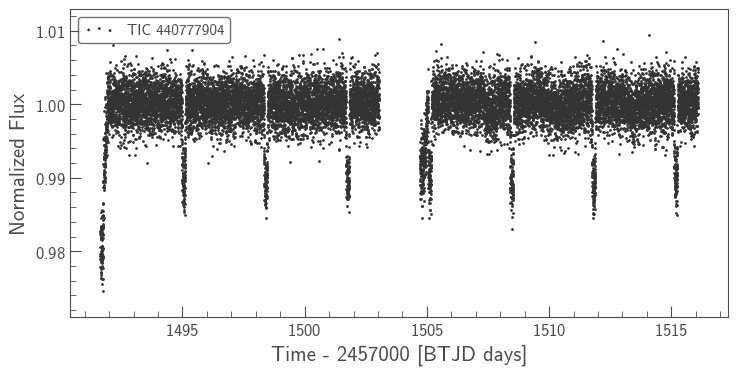

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -48422.99093888202 -> -48328.0700258698


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -37981.43693314356 -> -37710.10360405771


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -37710.10360405771 -> -37072.17458319083


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -37072.17458319083 -> -36873.38738297444


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -36873.38738297444 -> -36862.17500475896


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -36862.17500475896 -> -36854.86435524843


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -36854.86435524843 -> -36776.2095865736


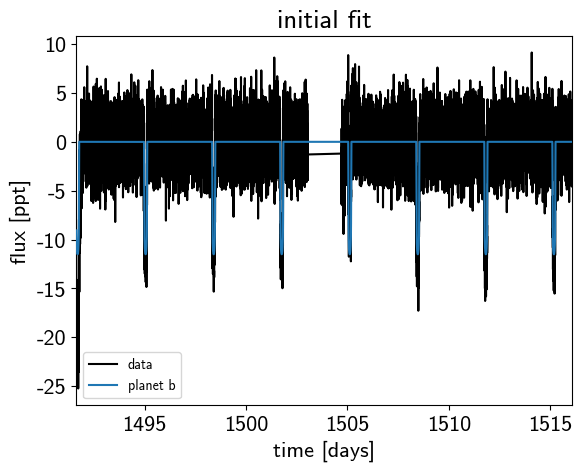

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:00, 95.56draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:15,  5.88draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:18,  4.88draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.35draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:31,  2.66draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:27,  2.96draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:34,  2.37draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:27,  2.91draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:35,  2.25draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:31,  2.53draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:33,  2.33draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:33,  2.31draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:29,  2.58draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:27,  2.71draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:28,  2.61draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:29,  2.49draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:29,  2.43draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:29,  2.43draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:28,  2.43draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:31,  2.21draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:26,  2.57draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:28,  2.32draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:25,  2.60draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:27,  2.34draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:24,  2.65draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:25,  2.43draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:13<00:25,  2.45draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:14<00:24,  2.45draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:14<00:24,  2.47draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:23,  2.56draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:15<00:23,  2.47draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:15<00:21,  2.66draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:21,  2.59draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:19,  2.78draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:16<00:20,  2.67draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:17<00:18,  2.80draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:17<00:20,  2.50draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:17<00:18,  2.78draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:18<00:19,  2.53draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:18<00:19,  2.54draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:19<00:18,  2.59draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:19<00:19,  2.40draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:19<00:16,  2.72draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:20<00:20,  2.23draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:21<00:19,  2.25draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:22<00:17,  2.36draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:22<00:16,  2.42draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:23<00:14,  2.64draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:23<00:15,  2.45draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:24<00:17,  2.04draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:25<00:16,  2.09draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:25<00:14,  2.23draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:26<00:10,  2.84draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:26<00:13,  2.24draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:27<00:12,  2.32draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:28<00:10,  2.41draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:29<00:09,  2.45draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:29<00:07,  3.06draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:29<00:09,  2.32draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:29<00:07,  2.95draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:30<00:08,  2.32draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:31<00:07,  2.37draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:32<00:06,  2.48draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:32<00:05,  2.54draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:33<00:04,  2.54draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:33<00:03,  3.19draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:34<00:04,  2.37draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:34<00:02,  3.05draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:35<00:03,  2.43draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:35<00:02,  3.13draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:35<00:02,  2.46draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:36<00:01,  3.16draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:36<00:01,  2.47draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:36<00:00,  3.15draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:37<00:00,  2.45draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:39<00:01,  1.03s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:40<00:00,  1.09draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 13.26draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:16,  5.42draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:14,  6.23draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:26,  3.40draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:25,  3.42draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:38,  2.29draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:29,  2.96draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:41,  2.05draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:39,  2.12draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:36,  2.24draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:28,  2.74draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:30,  2.55draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:31,  2.48draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:25,  2.95draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:29,  2.51draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:24,  3.00draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:19,  3.63draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:22,  3.12draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:21,  3.22draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:23,  2.97draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:23,  2.95draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:26,  2.56draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:23,  2.76draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:25,  2.52draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:24,  2.62draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:25,  2.50draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:24,  2.58draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:24,  2.48draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:23,  2.50draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:23,  2.50draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:19,  3.00draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:21,  2.61draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:19,  2.85draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:21,  2.56draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:18,  2.79draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:20,  2.50draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:18,  2.69draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:19,  2.55draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:17<00:17,  2.79draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:18,  2.62draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:16,  2.84draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:17,  2.65draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:15,  2.82draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:18<00:16,  2.66draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:19<00:16,  2.59draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:15,  2.71draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:13,  3.05draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:12,  3.12draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:20<00:13,  2.73draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:14,  2.58draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:15,  2.27draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:22<00:13,  2.61draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:12,  2.77draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:23<00:14,  2.22draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:11,  2.87draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:13,  2.21draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:24<00:12,  2.35draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:25<00:11,  2.40draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:07,  3.24draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:26<00:10,  2.39draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:07,  3.03draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:27<00:09,  2.40draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:27<00:07,  2.98draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:08,  2.36draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:06,  2.90draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:28<00:07,  2.33draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:28<00:05,  2.88draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:29<00:06,  2.30draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:29<00:05,  2.70draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:30<00:05,  2.47draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:30<00:04,  2.93draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:30<00:03,  2.90draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:31<00:03,  2.88draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:31<00:02,  3.62draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:32<00:02,  2.56draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:33<00:01,  2.63draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:33<00:01,  3.32draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:34<00:00,  3.11draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:36<00:00,  1.11draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  1.16draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<00:43,  4.66draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:56,  3.55draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<00:48,  4.09draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<00:42,  4.70draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:32,  6.02draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:39,  4.89draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:01<00:30,  6.25draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:53,  3.59draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:46,  4.11draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:54,  3.47draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<01:00,  3.08draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:52,  3.53draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:44,  4.16draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:48,  3.81draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:47,  3.81draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<01:04,  2.81draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<00:54,  3.33draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:43,  4.11draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:32,  5.40draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:06<00:26,  6.58draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:07<00:33,  5.18draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:07<00:58,  2.91draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:50,  3.34draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:08<00:39,  4.19draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:08<00:40,  4.05draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:09<00:52,  3.12draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:44,  3.67draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:09<00:49,  3.27draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:10<00:49,  3.25draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:10<00:46,  3.43draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:10<00:39,  4.04draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:10<00:50,  3.13draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:53,  2.92draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:11<00:47,  3.26draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:12<01:03,  2.46draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:12<00:51,  2.95draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:13<00:46,  3.23draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:13<00:53,  2.76draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:14<00:45,  3.23draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:14<00:38,  3.81draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:14<00:51,  2.81draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:15<00:43,  3.28draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:15<00:41,  3.40draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:16<00:35,  3.95draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:16<00:38,  3.57draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:16<00:45,  2.99draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:17<00:45,  2.98draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:17<00:43,  3.13draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:17<00:36,  3.66draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:17<00:36,  3.65draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:18<00:47,  2.75draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:18<00:38,  3.37draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:18<00:31,  4.10draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:19<00:45,  2.82draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:19<00:35,  3.57draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:19<00:38,  3.28draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:20<00:43,  2.86draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:20<00:37,  3.31draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:21<00:42,  2.85draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:21<00:37,  3.24draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:21<00:46,  2.55draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:22<00:37,  3.15draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:22<00:31,  3.69draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:22<00:28,  4.06draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:23<00:38,  3.05draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:23<00:34,  3.33draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:23<00:39,  2.86draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:24<00:38,  2.95draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:24<00:30,  3.66draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:25<00:29,  3.65draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:25<00:25,  4.31draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:25<00:20,  5.14draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:25<00:15,  6.50draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:25<00:17,  6.00draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:26<00:23,  4.30draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:26<00:21,  4.69draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:27<00:22,  4.38draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:27<00:17,  5.50draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:27<00:15,  6.18draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:27<00:26,  3.45draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:28<00:22,  4.02draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:28<00:17,  5.11draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:28<00:16,  5.36draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:29<00:26,  3.32draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:29<00:24,  3.51draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:29<00:25,  3.29draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:30<00:36,  2.29draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:30<00:28,  2.96draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:30<00:24,  3.33draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:31<00:21,  3.79draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:31<00:23,  3.47draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:31<00:20,  3.86draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:31<00:17,  4.39draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:32<00:21,  3.55draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:32<00:23,  3.23draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:33<00:24,  2.97draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:33<00:22,  3.21draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:33<00:24,  2.88draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:34<00:27,  2.59draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:34<00:22,  3.17draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:35<00:28,  2.42draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:35<00:22,  3.02draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:35<00:21,  3.12draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:35<00:21,  3.09draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:36<00:21,  3.00draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:36<00:19,  3.23draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:36<00:16,  3.69draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:36<00:13,  4.36draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:36<00:11,  5.09draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:37<00:11,  5.15draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:37<00:12,  4.66draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:38<00:11,  4.66draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:38<00:09,  5.52draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:39<00:13,  3.82draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:39<00:12,  3.85draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:39<00:09,  4.77draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:39<00:10,  4.42draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:40<00:10,  4.09draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:40<00:09,  4.64draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:40<00:08,  4.70draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:41<00:10,  3.94draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:41<00:09,  4.06draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:41<00:07,  4.91draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:41<00:06,  5.29draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:41<00:06,  5.82draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:42<00:06,  5.68draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:42<00:07,  4.53draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:42<00:08,  3.94draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:42<00:05,  5.01draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:43<00:05,  5.54draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:43<00:07,  3.64draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:43<00:06,  4.17draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:44<00:08,  2.99draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:44<00:06,  3.79draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:44<00:04,  4.40draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:45<00:06,  3.47draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:45<00:07,  2.59draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:46<00:07,  2.46draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:46<00:08,  2.10draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:47<00:09,  1.86draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:48<00:08,  1.81draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:48<00:06,  2.05draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:49<00:06,  1.92draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:49<00:05,  2.37draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:50<00:05,  2.11draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:50<00:03,  2.32draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:51<00:03,  2.40draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:51<00:02,  2.43draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:52<00:02,  2.27draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:52<00:01,  2.95draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:52<00:01,  2.42draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:53<00:01,  2.14draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:54<00:01,  1.95draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:54<00:00,  1.84draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:56<00:00,  1.08s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:12, 32.99draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:12, 31.79draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:15, 25.61draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:16, 23.38draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:15, 25.26draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:00<00:14, 26.39draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:15, 25.28draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:16, 23.04draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:01<00:14, 25.95draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:01<00:12, 29.38draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:12, 28.07draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:12, 29.81draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:01<00:13, 27.05draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:01<00:14, 24.07draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:02<00:15, 22.39draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:02<00:14, 23.36draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:02<00:21, 15.93draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:02<00:20, 16.54draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:02<00:22, 14.81draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:03<00:25, 12.92draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:03<00:31, 10.56draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:03<00:27, 12.13draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:03<00:22, 14.57draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:03<00:19, 16.96draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:03<00:16, 19.02draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:03<00:15, 21.11draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:04<00:13, 23.09draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:04<00:13, 22.17draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:04<00:13, 22.97draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:04<00:12, 24.52draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:04<00:11, 26.08draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:04<00:10, 28.15draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:04<00:10, 27.27draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:04<00:09, 29.82draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:05<00:11, 25.50draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:05<00:15, 18.03draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:05<00:14, 18.79draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:05<00:14, 19.62draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:05<00:12, 21.38draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:05<00:11, 22.61draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:06<00:12, 21.86draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:06<00:10, 25.14draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:06<00:10, 24.18draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:06<00:14, 17.81draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:06<00:12, 20.06draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:06<00:14, 17.80draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:07<00:11, 21.15draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:07<00:10, 23.51draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:07<00:09, 24.50draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:07<00:09, 23.86draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:07<00:10, 22.38draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:07<00:09, 23.52draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:07<00:09, 22.78draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:07<00:09, 22.50draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:08<00:08, 25.52draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:08<00:07, 29.76draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:08<00:07, 29.31draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:08<00:07, 26.33draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:08<00:07, 27.39draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:08<00:07, 26.58draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:08<00:06, 30.82draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:09<00:06, 28.72draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:09<00:06, 27.81draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:09<00:06, 26.96draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:09<00:06, 25.69draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:09<00:06, 28.39draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:09<00:05, 31.35draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:09<00:05, 29.60draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:10<00:05, 29.58draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:10<00:04, 34.27draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:10<00:05, 29.35draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:10<00:05, 28.69draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:10<00:05, 24.82draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:10<00:05, 27.06draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:10<00:04, 27.96draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:11<00:05, 22.97draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:11<00:06, 18.06draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:11<00:06, 18.95draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:11<00:06, 19.40draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:11<00:05, 21.17draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:12<00:05, 22.07draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:12<00:05, 21.80draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:12<00:04, 22.73draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:12<00:04, 24.61draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:12<00:03, 25.60draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:12<00:03, 25.92draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:12<00:03, 28.16draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:12<00:02, 31.61draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:13<00:02, 32.58draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:13<00:02, 33.30draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:13<00:02, 34.78draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:13<00:02, 28.67draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:13<00:02, 27.12draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:13<00:02, 25.50draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:13<00:02, 22.55draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:14<00:02, 23.54draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:14<00:02, 22.73draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:14<00:02, 21.94draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:14<00:02, 23.06draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:14<00:01, 25.89draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:14<00:01, 27.71draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:14<00:01, 28.97draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:14<00:00, 32.69draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:15<00:00, 33.25draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:15<00:00, 26.14draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:15<00:00, 24.61draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:15<00:00, 22.94draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:15<00:00, 17.17draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:16<00:00, 17.79draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:16<00:00, 17.61draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:16<00:00, 14.23draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:16<00:00, 13.28draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:16<00:00, 14.15draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:16<00:00, 24.07draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:22, 36.02draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:23, 34.03draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:22, 35.12draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:21, 37.25draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:34, 22.80draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:39, 19.87draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<00:39, 19.80draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:43, 17.75draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:01<00:39, 19.77draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:01<00:33, 23.07draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:47, 16.04draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:02<00:50, 15.15draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:02<00:47, 16.16draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:02<00:49, 15.22draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:02<00:43, 17.39draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:02<00:43, 17.38draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:02<00:40, 18.38draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:02<00:39, 19.08draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:02<00:37, 19.82draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:03<00:42, 17.55draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:03<00:44, 16.50draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:03<00:40, 18.12draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:03<00:43, 16.93draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:03<00:46, 15.62draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:03<00:47, 15.40draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:04<00:47, 15.22draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:04<00:43, 16.76draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:04<00:40, 17.90draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:37, 19.28draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:04<00:35, 20.17draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:04<00:38, 18.69draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:04<00:43, 16.38draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:05<00:41, 17.04draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:05<00:36, 19.17draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:05<00:38, 18.01draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:05<00:42, 16.42draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:05<00:44, 15.53draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:05<00:47, 14.78draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:05<00:43, 16.04draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:06<00:42, 16.31draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:06<00:37, 18.52draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:06<00:36, 18.87draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:06<00:35, 18.95draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:06<00:35, 18.97draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:06<00:34, 19.52draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:06<00:35, 18.89draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:07<00:40, 16.43draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:07<00:40, 16.55draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:07<00:36, 18.14draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:07<00:34, 19.28draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:07<00:29, 21.96draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:07<00:28, 22.60draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:07<00:26, 24.70draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:08<00:32, 20.15draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:08<00:40, 15.79draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:08<00:46, 13.86draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:08<00:46, 13.89draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:08<00:43, 14.54draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:08<00:38, 16.46draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:09<00:33, 18.68draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:09<00:29, 21.03draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:09<00:27, 22.64draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:09<00:26, 23.85draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:09<00:25, 24.13draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:09<00:22, 27.20draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:09<00:24, 25.19draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:09<00:23, 26.00draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:10<00:24, 24.21draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:10<00:25, 23.18draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:10<00:22, 26.13draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:10<00:19, 30.48draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:10<00:19, 29.68draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:10<00:24, 23.45draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:11<00:26, 21.92draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:11<00:24, 23.29draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:11<00:24, 23.71draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:11<00:26, 21.58draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:11<00:24, 22.80draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:11<00:21, 25.81draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:11<00:19, 28.68draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:11<00:20, 27.59draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:12<00:20, 27.21draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:12<00:20, 27.38draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:12<00:21, 25.86draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:12<00:23, 23.03draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:12<00:25, 20.91draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:12<00:23, 22.77draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:12<00:22, 23.62draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:12<00:20, 26.53draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:13<00:20, 25.31draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:13<00:23, 22.65draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:13<00:20, 25.96draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:13<00:18, 28.52draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:13<00:16, 30.61draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:13<00:19, 25.60draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:13<00:19, 26.49draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:14<00:19, 25.87draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:14<00:17, 28.54draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:14<00:17, 28.38draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:14<00:17, 28.20draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:14<00:20, 23.93draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:14<00:22, 21.46draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:14<00:22, 21.89draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:15<00:22, 21.13draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:15<00:21, 21.93draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:15<00:19, 24.28draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:15<00:17, 26.68draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:15<00:17, 26.87draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:15<00:18, 24.53draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:15<00:19, 23.31draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:16<00:18, 24.35draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:16<00:17, 25.42draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:16<00:17, 24.83draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:16<00:16, 26.73draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:16<00:16, 26.87draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:16<00:15, 27.27draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:16<00:18, 23.44draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:16<00:18, 23.76draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:17<00:17, 24.70draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:17<00:16, 25.65draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:17<00:15, 26.73draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:17<00:13, 30.37draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:17<00:15, 27.33draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:17<00:15, 26.76draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:17<00:14, 28.71draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:17<00:13, 29.45draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:18<00:13, 28.42draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:18<00:14, 26.53draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:18<00:14, 27.20draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:18<00:14, 26.71draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:18<00:13, 29.30draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:18<00:12, 30.71draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:18<00:12, 29.37draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:18<00:12, 29.35draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:19<00:11, 31.68draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:19<00:10, 33.70draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:19<00:12, 27.62draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:19<00:13, 25.80draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:19<00:14, 24.78draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:19<00:15, 22.88draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:20<00:15, 22.09draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:20<00:13, 25.46draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:20<00:14, 23.99draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:20<00:14, 22.51draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:20<00:13, 24.42draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:20<00:14, 22.99draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:20<00:13, 24.10draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:21<00:16, 19.51draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:21<00:17, 18.31draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:21<00:20, 15.73draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:21<00:18, 16.62draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:21<00:18, 16.89draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:21<00:21, 14.05draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:21<00:18, 16.39draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:22<00:18, 16.88draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:22<00:16, 17.87draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:22<00:14, 21.07draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:22<00:12, 23.07draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:22<00:13, 22.06draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:22<00:12, 22.19draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:22<00:12, 22.18draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:23<00:12, 23.04draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:23<00:11, 23.01draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:23<00:11, 23.72draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:23<00:09, 27.06draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:23<00:11, 23.09draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:23<00:10, 25.81draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:23<00:10, 25.42draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:23<00:09, 27.69draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:24<00:08, 27.95draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:24<00:09, 25.23draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:24<00:09, 25.40draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:24<00:09, 26.12draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:24<00:08, 27.82draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:24<00:08, 28.00draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:24<00:08, 28.38draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:24<00:07, 29.68draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:25<00:07, 28.05draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:25<00:10, 21.79draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:25<00:10, 20.85draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:25<00:10, 20.69draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:25<00:12, 16.59draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:26<00:13, 15.41draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:26<00:13, 15.46draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:26<00:14, 14.34draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:26<00:13, 15.05draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:26<00:14, 13.37draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:27<00:18, 10.61draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:27<00:18, 10.59draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:27<00:16, 11.95draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:27<00:13, 13.68draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:27<00:13, 13.41draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:27<00:12, 14.27draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:27<00:13, 13.36draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:28<00:13, 13.34draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:28<00:13, 13.33draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:28<00:12, 14.48draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:28<00:11, 15.79draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:28<00:16, 10.31draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:29<00:19,  8.78draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:29<00:20,  8.11draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:29<00:22,  7.55draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:29<00:22,  7.24draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:29<00:24,  6.85draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:30<00:22,  7.23draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:30<00:23,  6.91draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:30<00:23,  6.73draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:30<00:24,  6.63draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:30<00:23,  6.79draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:30<00:22,  7.15draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:30<00:20,  7.51draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:31<00:20,  7.63draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:31<00:16,  9.18draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:31<00:14, 10.58draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:31<00:12, 12.14draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:31<00:11, 13.05draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:31<00:10, 14.27draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:31<00:10, 13.86draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:31<00:10, 14.19draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:32<00:09, 15.33draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:32<00:09, 15.14draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:32<00:09, 13.70draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:32<00:11, 12.15draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:32<00:12, 10.89draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:33<00:12, 10.12draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:33<00:11, 10.86draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:33<00:13,  9.11draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:33<00:15,  7.97draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:34<00:22,  5.39draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:34<00:27,  4.46draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:34<00:24,  4.85draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:34<00:26,  4.50draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:35<00:21,  5.57draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:35<00:16,  6.85draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:35<00:14,  7.69draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:35<00:13,  8.45draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:35<00:11,  9.72draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:35<00:09, 11.14draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:35<00:09, 11.62draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:36<00:09, 11.05draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:36<00:09, 10.97draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:36<00:10,  9.91draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:36<00:11,  8.67draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:37<00:10,  8.93draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:37<00:09,  9.85draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:37<00:12,  7.70draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:37<00:14,  6.39draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:37<00:13,  6.98draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:38<00:11,  7.64draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:38<00:10,  8.15draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:38<00:10,  8.58draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:38<00:09,  8.83draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:38<00:09,  8.99draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:38<00:09,  9.02draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:38<00:08,  9.81draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:38<00:08,  9.31draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:39<00:08,  9.43draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:39<00:08,  9.13draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:39<00:07, 10.02draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:39<00:06, 10.80draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:39<00:06, 10.46draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:39<00:06, 11.02draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:40<00:05, 11.38draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:40<00:06, 10.91draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:40<00:06, 10.41draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:40<00:05, 11.46draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:40<00:05, 11.89draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:40<00:04, 11.73draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:41<00:04, 12.01draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:41<00:04, 12.22draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:41<00:04, 12.85draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:41<00:03, 13.05draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [00:41<00:03, 13.30draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:41<00:03, 14.50draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:42<00:03, 11.99draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:42<00:03, 12.19draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:42<00:05,  6.75draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:43<00:05,  6.87draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:43<00:05,  6.90draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:43<00:04,  7.28draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:43<00:04,  7.83draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:43<00:04,  7.97draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:43<00:03,  9.54draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:43<00:02, 10.31draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:44<00:02, 10.99draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:44<00:02, 11.69draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:44<00:02, 11.26draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:44<00:02, 10.39draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:44<00:01, 11.23draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:44<00:01, 10.88draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:45<00:01, 10.78draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:45<00:01, 10.65draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:45<00:01, 10.53draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:45<00:00, 12.33draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:45<00:00, 14.03draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:45<00:00, 15.53draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:46<00:00, 15.43draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<10:49,  6.77draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<08:02,  9.11draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<06:43, 10.88draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<05:12, 14.06draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:35, 15.95draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<04:02, 18.10draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:00<03:28, 21.05draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:00<03:01, 24.14draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<02:46, 26.34draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<02:46, 26.26draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:01<02:40, 27.27draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:01<04:44, 15.35draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:01<04:31, 16.08draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<04:19, 16.80draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:02<03:45, 19.32draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<03:39, 19.84draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<04:06, 17.62draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:02<03:36, 20.10draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:02<03:04, 23.50draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:02<02:37, 27.45draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:03<02:48, 25.76draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:03<03:19, 21.74draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:03<03:11, 22.59draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:03<03:07, 23.03draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<03:15, 22.04draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:03<03:05, 23.21draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:03<03:00, 23.87draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:04<02:46, 25.88draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:04<02:55, 24.46draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:04<02:43, 26.35draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:04<03:31, 20.28draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:04<03:41, 19.36draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<03:07, 22.90draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:04<02:57, 24.12draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:05<03:13, 22.13draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:05<03:19, 21.50draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<03:04, 23.14draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:05<03:36, 19.77draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:05<03:47, 18.73draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:05<03:15, 21.86draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:05<02:49, 25.13draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:06<02:28, 28.67draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:06<02:23, 29.69draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:06<02:45, 25.62draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:06<03:02, 23.30draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:06<03:13, 21.93draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:06<03:20, 21.18draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:07<03:18, 21.35draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:07<03:04, 22.94draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:07<03:20, 21.15draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:07<03:56, 17.86draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:07<03:44, 18.83draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:07<03:11, 22.07draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:07<03:03, 23.01draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:08<02:50, 24.64draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:08<02:55, 23.99draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:08<02:51, 24.53draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:08<02:48, 24.97draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:08<02:39, 26.29draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:08<02:32, 27.58draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:08<02:19, 29.96draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:08<02:12, 31.59draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:09<02:15, 30.76draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:09<02:08, 32.58draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:09<02:08, 32.59draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:09<02:02, 34.12draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:09<02:21, 29.36draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:09<02:13, 31.18draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:09<02:37, 26.45draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:10<03:10, 21.76draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:10<02:43, 25.36draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:10<02:39, 26.07draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:10<02:38, 26.22draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:10<02:39, 25.97draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:10<02:47, 24.76draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:10<02:45, 25.01draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:11<02:41, 25.62draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:11<02:35, 26.48draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:11<02:37, 26.18draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:11<02:38, 26.02draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:11<02:35, 26.51draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:11<02:41, 25.51draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:11<03:00, 22.76draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:11<02:41, 25.48draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:11<02:39, 25.66draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:12<02:29, 27.46draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:12<02:27, 27.71draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:12<02:18, 29.50draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:12<02:16, 29.92draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:12<02:10, 31.23draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:12<02:20, 29.13draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:12<02:12, 30.83draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:12<02:08, 31.78draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:13<02:52, 23.59draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:13<02:54, 23.27draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:13<02:57, 22.93draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:13<02:37, 25.78draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:13<02:23, 28.28draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:13<02:30, 26.88draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:14<02:35, 26.07draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:14<02:40, 25.19draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:14<02:41, 25.02draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:14<02:39, 25.26draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:14<02:28, 27.22draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:14<02:20, 28.62draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:14<02:13, 30.14draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:14<02:09, 31.15draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:15<02:16, 29.54draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:15<02:07, 31.44draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:15<02:04, 32.32draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:15<02:14, 29.76draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:15<02:11, 30.42draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:15<02:45, 24.16draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:15<03:03, 21.74draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:16<03:12, 20.71draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:16<03:29, 19.04draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:16<03:22, 19.71draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:16<03:10, 20.92draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:16<03:28, 19.06draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:16<03:43, 17.77draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:17<03:26, 19.20draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:17<03:27, 19.17draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:17<03:36, 18.35draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:17<03:15, 20.28draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:17<03:50, 17.21draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:17<04:11, 15.74draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:18<03:38, 18.10draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:18<03:39, 17.99draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:18<03:33, 18.47draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:18<03:09, 20.80draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:18<03:35, 18.31draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:18<03:21, 19.55draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:18<03:36, 18.21draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:19<03:55, 16.75draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:19<03:51, 17.02draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:19<03:47, 17.26draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:19<03:27, 18.92draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:19<03:23, 19.28draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:19<03:23, 19.25draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:19<03:21, 19.44draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:20<03:14, 20.11draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [00:20<03:04, 21.19draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:20<03:12, 20.34draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:20<03:27, 18.83draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:20<03:30, 18.53draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:20<03:55, 16.56draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:21<03:48, 17.07draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:21<04:42, 13.81draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:21<04:22, 14.86draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:21<04:40, 13.91draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:21<04:19, 15.00draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:21<04:02, 16.03draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:21<03:51, 16.78draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:22<03:29, 18.57draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:22<03:29, 18.51draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:22<02:59, 21.66draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:22<03:10, 20.39draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:22<03:44, 17.27draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:22<04:04, 15.84draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:22<03:49, 16.88draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:23<03:40, 17.53draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:23<03:51, 16.71draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:23<03:44, 17.19draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:23<03:40, 17.54draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:23<03:15, 19.77draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:23<03:37, 17.71draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:23<03:29, 18.35draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:24<03:22, 19.05draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:24<03:06, 20.59draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:24<02:58, 21.48draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:24<02:51, 22.37draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:24<02:30, 25.39draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:24<02:39, 23.99draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:24<02:27, 25.95draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:25<02:06, 30.07draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:25<01:58, 32.09draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:25<01:58, 32.12draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:25<01:57, 32.30draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:25<02:15, 28.14draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:25<02:29, 25.39draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:25<02:19, 27.13draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:25<02:20, 26.94draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:26<02:15, 28.02draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:26<02:17, 27.52draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:26<02:18, 27.21draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:26<02:16, 27.73draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:26<02:13, 28.28draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:26<02:12, 28.52draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:26<02:12, 28.44draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:26<02:02, 30.66draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:27<01:55, 32.48draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:27<02:08, 29.23draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:27<02:06, 29.55draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:27<02:01, 30.92draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:27<02:21, 26.53draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:27<02:25, 25.69draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:27<02:19, 26.78draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:27<02:20, 26.65draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:28<02:31, 24.59draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:28<02:18, 26.95draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:28<02:01, 30.58draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:28<02:05, 29.56draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:28<02:25, 25.59draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:28<02:25, 25.50draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:28<02:19, 26.50draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:29<02:05, 29.39draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:29<02:14, 27.58draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:29<02:14, 27.49draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:29<02:06, 29.15draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:29<02:18, 26.57draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:29<02:21, 26.08draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:29<02:32, 24.12draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:30<02:24, 25.40draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:30<02:10, 28.09draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:30<01:58, 30.90draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:30<01:53, 32.35draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:30<01:47, 34.01draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:30<01:44, 35.04draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:30<01:42, 35.51draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:30<01:42, 35.66draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:30<01:52, 32.36draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:31<01:46, 34.15draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:31<01:38, 36.81draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:31<01:56, 31.11draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:31<01:45, 34.22draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:31<02:02, 29.51draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:31<01:54, 31.68draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:31<01:49, 32.96draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [00:31<01:55, 31.19draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:32<01:53, 31.78draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:32<01:49, 32.88draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:32<01:44, 34.42draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:32<01:43, 34.58draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:32<01:42, 34.97draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:32<01:40, 35.68draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:32<01:41, 35.12draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:33<01:42, 34.84draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [00:33<01:52, 31.63draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:33<01:50, 32.20draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:33<01:48, 32.80draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:33<01:48, 32.78draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:33<02:15, 26.20draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:33<02:28, 23.89draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:34<02:24, 24.58draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:34<02:22, 24.93draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:34<02:54, 20.27draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:34<02:56, 20.06draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:34<03:00, 19.64draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:34<03:00, 19.60draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:34<02:50, 20.73draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:35<02:28, 23.67draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:35<02:34, 22.83draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:35<02:19, 25.32draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [00:35<02:08, 27.42draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:35<02:24, 24.28draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:35<02:36, 22.42draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:35<02:55, 19.92draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:36<03:44, 15.58draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:36<03:18, 17.64draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:36<03:11, 18.29draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:36<03:04, 18.98draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:37<04:12, 13.84draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:37<04:33, 12.75draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:37<04:31, 12.87draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:37<04:25, 13.14draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [00:37<04:21, 13.32draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:37<04:23, 13.19draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:37<04:26, 13.05draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:38<03:55, 14.77draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:38<03:56, 14.67draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:38<03:59, 14.48draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:38<03:47, 15.27draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:38<03:17, 17.56draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [00:38<03:59, 14.45draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:38<03:15, 17.74draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:39<02:58, 19.35draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [00:39<02:32, 22.60draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [00:39<02:27, 23.38draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:39<02:23, 23.96draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:39<02:08, 26.77draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:39<02:07, 27.07draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:39<02:52, 19.94draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:39<02:45, 20.76draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:40<02:31, 22.65draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:40<02:28, 23.13draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:40<02:33, 22.30draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [00:40<02:23, 23.78draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:40<02:16, 25.04draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:40<02:14, 25.37draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:40<02:12, 25.73draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:41<02:20, 24.19draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:41<02:17, 24.69draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:41<02:15, 25.02draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:41<02:22, 23.83draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:41<02:07, 26.52draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:41<02:21, 23.92draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:41<02:01, 27.92draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:42<01:55, 29.32draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:42<01:56, 29.05draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:42<02:04, 27.19draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:42<02:22, 23.71draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [00:42<02:30, 22.34draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:42<02:24, 23.31draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:42<02:03, 27.22draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:43<02:09, 25.92draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [00:43<02:00, 27.82draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:43<02:10, 25.60draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:43<02:01, 27.55draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:43<02:15, 24.70draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:43<02:22, 23.47draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:43<02:14, 24.85draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:44<02:41, 20.63draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [00:44<02:44, 20.21draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:44<02:29, 22.29draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:44<02:23, 23.17draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:44<02:25, 22.80draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:44<02:20, 23.57draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:44<02:17, 24.15draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:44<02:24, 22.93draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:45<02:27, 22.46draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [00:45<03:01, 18.24draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:45<03:00, 18.28draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [00:45<03:07, 17.58draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:45<02:52, 19.10draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:45<02:54, 18.86draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:45<02:54, 18.81draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:46<02:55, 18.72draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [00:46<03:15, 16.85draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:46<03:18, 16.52draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [00:46<02:55, 18.66draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:46<02:44, 19.93draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [00:46<02:33, 21.38draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:46<02:22, 23.04draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:46<02:15, 24.21draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:47<02:01, 26.99draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:47<03:24, 15.93draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [00:47<03:52, 14.02draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [00:47<03:42, 14.67draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:47<03:40, 14.76draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:48<03:32, 15.30draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:48<03:19, 16.31draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:48<03:11, 16.99draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:48<02:51, 18.90draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:48<02:39, 20.35draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:48<02:18, 23.41draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:48<02:01, 26.51draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:48<01:55, 27.88draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:49<02:08, 25.05draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:49<02:10, 24.74draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:49<02:20, 22.84draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:49<02:13, 24.09draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:49<02:10, 24.71draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:49<01:50, 29.01draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:49<01:46, 30.21draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:49<01:35, 33.66draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:50<01:33, 34.17draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [00:50<01:40, 31.89draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [00:50<01:43, 30.71draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [00:50<01:39, 32.03draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [00:50<01:46, 29.80draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:50<01:52, 28.35draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:50<01:53, 27.84draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:51<02:05, 25.21draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:51<02:06, 24.98draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [00:51<02:02, 25.86draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:51<01:59, 26.36draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:51<01:45, 29.94draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:51<01:47, 29.30draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:51<01:40, 31.45draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:51<01:46, 29.57draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:52<01:46, 29.36draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [00:52<01:57, 26.71draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:52<01:49, 28.59draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:52<01:46, 29.41draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:52<01:43, 30.10draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:52<01:38, 31.77draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [00:52<01:44, 29.86draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [00:52<01:37, 32.04draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [00:53<01:43, 30.10draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [00:53<01:41, 30.55draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [00:53<01:43, 30.00draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:53<01:50, 28.07draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:53<01:54, 27.10draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [00:53<02:26, 21.04draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [00:53<02:25, 21.16draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:54<02:19, 22.09draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:54<02:00, 25.62draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:54<01:57, 26.27draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [00:54<01:53, 27.08draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [00:54<01:50, 27.68draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:54<01:41, 30.27draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:54<01:35, 32.06draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:54<01:43, 29.62draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:55<01:48, 28.07draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [00:55<02:05, 24.30draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:55<02:14, 22.58draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:55<02:13, 22.76draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [00:55<02:18, 21.98draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [00:55<02:15, 22.37draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:56<02:19, 21.80draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:56<02:12, 22.93draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:56<01:59, 25.29draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [00:56<02:03, 24.46draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:56<02:06, 23.92draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:56<02:10, 23.18draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [00:56<02:02, 24.58draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [00:56<02:17, 21.84draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [00:57<02:15, 22.28draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:57<02:04, 24.11draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:57<01:48, 27.57draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:57<01:41, 29.46draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [00:57<01:36, 31.15draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:57<01:30, 32.90draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:57<01:42, 29.06draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:58<01:50, 26.99draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [00:58<01:46, 27.81draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:58<01:38, 30.01draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [00:58<01:36, 30.70draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [00:58<01:35, 31.16draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:58<01:32, 32.12draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:58<01:41, 29.03draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [00:58<01:52, 26.31draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:59<01:48, 27.02draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:59<01:53, 26.00draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [00:59<02:01, 24.17draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [00:59<02:03, 23.82draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:59<01:59, 24.54draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [00:59<02:02, 23.85draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [00:59<01:58, 24.64draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:00<01:56, 25.21draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:00<02:03, 23.63draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:00<01:57, 24.76draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [01:00<02:05, 23.32draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:00<02:21, 20.60draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [01:00<02:34, 18.80draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:00<02:41, 18.03draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:01<02:36, 18.58draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:01<02:19, 20.81draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:01<02:26, 19.79draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:01<02:21, 20.53draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:01<02:14, 21.44draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:01<02:00, 23.88draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [01:01<01:59, 24.08draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [01:01<02:08, 22.37draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:02<02:08, 22.36draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:02<02:06, 22.71draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [01:02<02:17, 20.93draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [01:02<02:08, 22.38draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:02<02:05, 22.92draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [01:02<01:57, 24.38draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [01:02<01:56, 24.63draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [01:03<01:55, 24.71draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [01:03<01:30, 31.44draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [01:03<01:21, 34.86draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [01:03<02:12, 21.40draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:04<02:21, 20.05draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:04<03:03, 15.43draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [01:04<03:13, 14.58draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:04<03:26, 13.65draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:04<03:37, 12.98draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:05<03:39, 12.84draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:05<03:41, 12.70draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [01:05<03:41, 12.68draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [01:05<03:09, 14.84draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:05<02:59, 15.67draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [01:05<02:51, 16.37draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:05<02:54, 16.11draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:06<02:43, 17.18draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:06<02:24, 19.37draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [01:06<02:42, 17.20draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:06<02:39, 17.51draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [01:06<02:22, 19.56draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [01:06<02:16, 20.39draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:06<02:15, 20.54draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:07<02:03, 22.50draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [01:07<01:59, 23.28draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:07<01:57, 23.67draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [01:07<02:09, 21.38draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:07<02:07, 21.73draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:07<01:57, 23.59draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [01:07<01:40, 27.45draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [01:07<01:27, 31.45draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:08<01:19, 34.55draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [01:08<01:12, 38.08draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [01:08<01:11, 38.42draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [01:08<01:10, 38.94draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [01:08<01:16, 35.52draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:08<01:27, 31.24draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [01:08<01:35, 28.55draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:09<01:37, 27.88draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [01:09<01:40, 27.06draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [01:09<01:42, 26.47draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:09<01:45, 25.76draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [01:09<01:47, 25.12draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [01:09<02:01, 22.20draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [01:09<01:51, 24.12draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [01:09<01:47, 25.07draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [01:10<01:46, 25.19draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [01:10<01:44, 25.81draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [01:10<01:56, 23.06draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:10<02:02, 21.97draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:10<02:13, 20.02draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:10<02:02, 21.80draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:10<01:55, 23.13draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:11<01:57, 22.79draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:11<01:59, 22.35draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [01:11<02:09, 20.60draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [01:11<01:59, 22.36draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [01:11<01:53, 23.54draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [01:11<01:53, 23.36draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:11<01:43, 25.75draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:11<01:39, 26.61draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:12<01:37, 27.17draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:12<01:35, 27.59draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:12<01:22, 32.16draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:12<01:24, 31.01draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:12<01:30, 29.08draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:12<01:21, 32.28draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:12<01:19, 32.78draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [01:12<01:16, 34.01draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:13<01:32, 28.38draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:13<01:41, 25.76draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:13<01:34, 27.46draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:13<01:42, 25.44draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:13<01:43, 25.06draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:13<01:49, 23.65draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:14<02:15, 19.13draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:14<02:05, 20.67draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:14<01:55, 22.45draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:14<01:56, 22.23draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [01:14<01:48, 23.77draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:14<01:43, 25.00draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [01:14<01:43, 24.88draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [01:14<01:42, 25.15draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [01:15<01:44, 24.65draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [01:15<01:55, 22.11draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [01:15<02:19, 18.30draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [01:15<02:07, 20.00draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:15<02:05, 20.38draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:15<01:49, 23.37draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:15<01:44, 24.39draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:16<01:49, 23.24draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:16<01:42, 24.68draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:16<01:34, 26.85draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:16<01:51, 22.74draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:16<01:38, 25.78draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:16<01:36, 26.21draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:16<01:37, 25.86draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:16<01:27, 28.72draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:17<01:32, 27.18draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:17<01:30, 27.72draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [01:17<01:34, 26.48draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:17<01:31, 27.39draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:17<01:25, 29.39draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:17<01:26, 28.79draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:17<01:28, 28.35draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:17<01:26, 28.73draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:18<01:20, 31.07draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:18<01:21, 30.45draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [01:18<01:28, 28.16draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:18<01:28, 27.95draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:18<01:30, 27.21draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:18<01:30, 27.29draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:18<01:35, 25.92draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [01:18<01:30, 27.36draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:19<01:27, 28.26draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:19<01:30, 27.17draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:19<01:29, 27.31draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:19<01:29, 27.52draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:19<01:29, 27.47draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [01:19<01:19, 30.72draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [01:19<01:24, 28.81draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:20<01:40, 24.20draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:20<01:47, 22.69draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:20<01:37, 25.03draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [01:20<01:40, 24.18draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [01:20<01:36, 24.99draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [01:20<01:26, 28.02draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [01:20<01:20, 30.04draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:20<01:15, 31.83draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:21<01:15, 31.75draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [01:21<01:13, 32.88draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [01:21<01:11, 33.71draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:21<01:14, 32.21draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [01:21<01:11, 33.33draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:21<01:16, 31.17draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:21<01:22, 28.86draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:21<01:25, 27.72draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:22<01:17, 30.69draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:22<01:14, 31.61draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:22<01:13, 32.32draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:22<01:10, 33.72draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:22<01:17, 30.43draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:22<01:27, 26.82draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:22<01:31, 25.62draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:22<01:30, 26.06draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:23<01:43, 22.55draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:23<01:46, 21.97draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:23<01:50, 21.14draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:23<02:00, 19.45draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:23<02:09, 17.95draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:23<01:56, 19.99draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [01:24<01:47, 21.60draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:24<01:34, 24.59draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:24<01:31, 25.34draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:24<01:32, 24.90draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:24<01:30, 25.44draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:24<01:31, 25.10draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:24<01:32, 25.00draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [01:24<01:35, 24.23draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [01:25<01:36, 23.91draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:25<01:31, 25.01draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:25<01:31, 24.97draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:25<01:41, 22.46draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:25<01:57, 19.39draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [01:25<01:46, 21.40draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [01:25<01:49, 20.90draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [01:26<01:56, 19.61draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:26<01:45, 21.61draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:26<01:46, 21.33draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [01:26<01:41, 22.42draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [01:26<01:33, 24.19draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:26<01:30, 25.02draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [01:26<01:28, 25.68draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:26<01:36, 23.51draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:27<01:30, 24.86draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:27<01:33, 24.01draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:27<01:40, 22.41draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [01:27<01:29, 25.05draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [01:27<01:22, 27.05draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:27<01:16, 29.32draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [01:27<01:10, 31.63draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [01:28<01:13, 30.46draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [01:28<01:30, 24.63draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:28<01:27, 25.31draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:28<01:31, 24.27draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:28<01:26, 25.70draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:28<01:23, 26.46draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:28<01:27, 25.10draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:28<01:27, 25.23draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:29<01:23, 26.48draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:29<01:16, 28.74draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [01:29<01:18, 27.92draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [01:29<01:17, 28.28draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [01:29<01:13, 29.94draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:29<01:18, 27.72draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [01:29<01:23, 26.01draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:29<01:26, 25.09draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:30<01:24, 25.78draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:30<01:34, 23.08draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [01:30<01:27, 24.67draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:30<01:33, 23.02draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:30<01:33, 23.15draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [01:30<01:42, 21.11draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [01:30<01:46, 20.19draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [01:31<01:40, 21.47draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:31<01:57, 18.29draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:31<01:40, 21.38draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:31<01:26, 24.67draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [01:31<01:19, 26.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [01:31<01:20, 26.36draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [01:31<01:18, 27.23draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:32<01:28, 23.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [01:32<01:25, 24.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [01:32<01:34, 22.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:32<01:33, 22.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [01:32<01:25, 24.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [01:32<01:25, 24.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [01:32<01:33, 22.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:33<01:41, 20.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:33<01:43, 20.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:33<01:44, 20.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [01:33<01:39, 21.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:33<01:25, 24.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [01:33<01:21, 25.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:33<01:21, 25.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [01:33<01:21, 25.59draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:34<01:18, 26.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:34<01:14, 28.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [01:34<01:21, 25.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [01:34<01:22, 25.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [01:34<01:26, 23.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:34<01:17, 26.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [01:34<01:21, 25.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:34<01:13, 27.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [01:35<01:14, 27.43draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:35<01:08, 29.92draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:35<01:10, 29.09draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [01:35<01:12, 28.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:35<01:07, 30.32draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:35<01:03, 31.82draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [01:35<01:06, 30.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [01:36<01:02, 32.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [01:36<01:03, 31.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [01:36<01:10, 28.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:36<01:14, 27.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:36<01:13, 27.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:36<01:13, 27.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [01:36<01:14, 26.74draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [01:36<01:14, 26.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:37<01:12, 27.67draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [01:37<01:11, 27.74draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [01:37<01:22, 24.11draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:37<01:19, 25.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [01:37<01:20, 24.62draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [01:37<01:16, 26.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:37<01:28, 22.20draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:37<01:26, 22.87draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [01:38<01:20, 24.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:38<01:13, 26.64draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:38<01:10, 27.73draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:38<01:11, 27.27draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:38<01:09, 27.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [01:38<01:08, 28.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:38<01:03, 30.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [01:38<01:03, 30.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [01:39<01:02, 30.79draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [01:39<01:08, 28.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:39<01:17, 25.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [01:39<01:18, 24.57draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [01:39<01:16, 25.05draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [01:39<01:14, 25.94draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:39<01:13, 26.23draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [01:39<01:12, 26.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:40<01:18, 24.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:40<01:10, 27.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [01:40<01:21, 23.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:40<01:18, 24.35draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:40<01:22, 23.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [01:40<01:23, 22.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [01:40<01:20, 23.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [01:41<01:13, 25.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [01:41<01:21, 23.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:41<01:16, 24.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [01:41<01:13, 25.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:41<01:07, 27.65draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:41<01:02, 29.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [01:41<01:08, 27.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [01:41<01:15, 24.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [01:42<01:22, 22.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [01:42<01:24, 22.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:42<01:21, 22.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:42<01:14, 24.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [01:42<01:11, 25.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [01:42<01:10, 26.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:42<01:16, 24.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:43<01:08, 26.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [01:43<01:09, 26.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [01:43<01:09, 26.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [01:43<01:09, 26.17draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [01:43<01:08, 26.81draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:43<01:03, 28.78draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [01:43<01:06, 27.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:43<01:01, 29.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:44<01:00, 29.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [01:44<01:08, 26.18draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [01:44<01:09, 26.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [01:44<01:07, 26.51draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [01:44<01:02, 28.81draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:44<01:05, 27.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:44<01:14, 23.98draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:44<01:20, 22.18draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [01:45<01:24, 21.00draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [01:45<01:26, 20.50draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:45<01:25, 20.82draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [01:45<01:21, 21.77draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [01:45<01:16, 23.03draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:45<01:20, 21.84draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:45<01:15, 23.40draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:46<01:17, 22.68draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:46<01:21, 21.70draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:46<01:18, 22.24draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [01:46<01:09, 25.33draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [01:46<01:05, 26.50draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [01:46<00:58, 29.62draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [01:46<00:52, 33.05draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:47<00:53, 32.68draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [01:47<00:48, 35.62draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [01:47<00:53, 32.11draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [01:47<00:57, 29.77draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [01:47<01:08, 25.11draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [01:47<01:06, 25.64draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [01:47<00:56, 30.33draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [01:47<00:52, 32.23draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [01:48<00:47, 36.03draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [01:48<00:55, 30.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:48<00:59, 28.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:48<00:57, 29.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:48<01:05, 25.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [01:48<01:08, 24.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [01:49<01:07, 24.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:49<01:24, 19.90draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:49<01:21, 20.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [01:49<01:32, 18.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [01:49<01:30, 18.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:49<01:28, 18.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [01:50<01:27, 18.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [01:50<01:18, 21.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [01:50<01:15, 22.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [01:50<01:25, 19.30draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [01:50<01:35, 17.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:50<01:41, 16.16draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:50<01:43, 15.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [01:51<01:37, 16.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:51<01:36, 17.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [01:51<01:50, 14.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [01:51<01:34, 17.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [01:51<01:30, 17.99draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:51<01:30, 17.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:51<01:32, 17.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [01:51<01:31, 17.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [01:52<01:27, 18.55draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:52<01:31, 17.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [01:52<01:33, 17.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [01:52<01:31, 17.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [01:52<01:28, 18.23draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [01:52<01:19, 20.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:52<01:29, 17.94draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [01:52<01:19, 20.16draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:53<01:22, 19.37draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:53<01:25, 18.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [01:53<01:26, 18.36draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [01:53<01:19, 20.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:53<01:18, 20.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [01:53<01:22, 19.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [01:53<01:23, 18.90draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [01:54<01:24, 18.84draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [01:54<01:19, 19.95draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:54<01:19, 19.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [01:54<01:14, 21.04draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [01:54<01:09, 22.63draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:54<01:06, 23.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [01:54<01:04, 24.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [01:55<01:02, 25.00draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [01:55<00:59, 26.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [01:55<00:54, 28.67draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:55<00:56, 27.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [01:55<00:52, 29.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [01:55<00:53, 29.06draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [01:55<00:47, 32.15draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [01:55<00:48, 31.75draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [01:56<00:57, 26.42draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [01:56<00:57, 26.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [01:56<00:58, 26.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:56<01:00, 25.03draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [01:56<00:50, 29.87draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:56<00:43, 34.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:56<00:38, 38.73draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [01:56<00:37, 39.78draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [01:57<00:39, 38.06draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [01:57<00:37, 39.67draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [01:57<00:37, 39.02draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [01:57<00:40, 36.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [01:57<00:40, 36.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [01:57<00:41, 35.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:57<00:49, 29.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [01:57<00:46, 31.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [01:58<00:48, 30.01draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [01:58<00:46, 31.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [01:58<00:49, 29.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [01:58<00:46, 30.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [01:58<00:51, 27.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [01:58<00:51, 27.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [01:58<00:58, 24.40draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [01:59<00:56, 25.52draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [01:59<00:51, 27.76draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [01:59<00:48, 29.45draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [01:59<00:44, 31.98draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [01:59<00:46, 30.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [01:59<00:52, 26.72draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [01:59<00:56, 24.91draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [02:00<00:56, 24.68draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [02:00<01:00, 23.02draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [02:00<01:00, 23.19draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:00<00:54, 25.57draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:00<00:50, 27.67draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [02:00<00:46, 29.94draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [02:00<00:45, 30.40draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:00<00:46, 29.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [02:01<00:49, 27.86draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [02:01<00:46, 29.67draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [02:01<00:47, 28.93draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [02:01<00:44, 30.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [02:01<00:48, 28.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [02:01<00:48, 27.88draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [02:01<00:45, 29.91draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [02:02<00:39, 33.68draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [02:02<00:39, 34.21draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [02:02<00:38, 35.06draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:02<00:37, 35.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [02:02<00:36, 36.06draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [02:02<00:34, 38.17draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [02:02<00:35, 36.92draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [02:02<00:35, 36.76draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [02:02<00:41, 31.75draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:03<00:40, 32.26draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [02:03<00:39, 32.65draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [02:03<00:39, 33.06draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:03<00:38, 33.88draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:03<00:43, 30.01draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:03<00:47, 26.89draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [02:03<00:45, 28.31draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [02:03<00:45, 28.41draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [02:04<00:41, 30.65draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [02:04<00:43, 29.06draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [02:04<00:47, 26.66draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [02:04<00:49, 25.59draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [02:04<00:55, 22.85draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [02:04<00:51, 24.38draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:04<00:48, 25.69draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [02:05<00:42, 29.17draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [02:05<00:36, 33.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [02:05<00:38, 32.02draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [02:05<00:41, 30.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [02:05<00:45, 27.13draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:05<00:45, 27.16draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [02:05<00:51, 23.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [02:06<00:49, 24.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [02:06<00:59, 20.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [02:06<00:55, 21.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [02:06<00:52, 23.19draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [02:06<00:46, 26.16draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:06<00:41, 28.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:06<00:41, 28.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [02:06<00:45, 26.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [02:07<00:43, 27.24draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [02:07<00:47, 25.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [02:07<00:47, 25.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [02:07<00:46, 25.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [02:07<00:42, 27.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [02:07<00:40, 28.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [02:07<00:39, 29.54draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [02:08<00:37, 30.95draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:08<00:40, 28.50draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:08<00:49, 23.40draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [02:08<00:50, 23.06draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [02:08<00:55, 20.73draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:08<00:51, 22.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:08<00:48, 23.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:09<00:43, 25.98draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [02:09<00:42, 26.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [02:09<00:41, 27.05draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [02:09<00:40, 28.17draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:09<00:38, 29.30draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [02:09<00:33, 33.39draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:09<00:34, 32.22draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [02:09<00:31, 34.80draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [02:10<00:29, 38.11draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [02:10<00:33, 32.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [02:10<00:35, 30.85draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [02:10<00:37, 29.48draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:10<00:42, 25.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [02:10<00:45, 23.75draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [02:11<00:45, 24.11draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [02:11<00:45, 23.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [02:11<00:47, 22.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [02:11<00:44, 23.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [02:11<00:42, 25.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [02:11<00:36, 29.09draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [02:11<00:40, 26.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [02:12<00:37, 27.98draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [02:12<00:34, 30.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:12<00:34, 30.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [02:12<00:37, 28.07draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [02:12<00:34, 30.06draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [02:12<00:35, 29.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [02:12<00:32, 31.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [02:12<00:34, 29.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [02:13<00:33, 30.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [02:13<00:36, 27.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [02:13<00:35, 28.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [02:13<00:36, 27.53draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:13<00:37, 27.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:13<00:36, 27.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [02:13<00:38, 26.00draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [02:13<00:37, 26.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [02:14<00:36, 27.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:14<00:36, 27.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [02:14<00:34, 28.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [02:14<00:32, 30.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:14<00:28, 33.89draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:14<00:28, 33.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [02:14<00:29, 33.13draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [02:14<00:28, 33.69draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [02:15<00:36, 26.56draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [02:15<00:38, 25.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [02:15<00:41, 23.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [02:15<00:35, 27.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:15<00:37, 25.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [02:15<00:36, 26.25draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:16<00:34, 27.22draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:16<00:33, 27.99draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [02:16<00:35, 26.41draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [02:16<00:35, 26.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [02:16<00:34, 26.97draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:16<00:32, 28.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:16<00:32, 28.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [02:16<00:30, 30.48draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [02:16<00:30, 30.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [02:17<00:34, 26.61draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [02:17<00:35, 25.91draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [02:17<00:32, 27.97draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [02:17<00:33, 27.26draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:17<00:35, 25.00draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [02:17<00:34, 26.26draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [02:17<00:34, 26.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [02:18<00:37, 23.76draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [02:18<00:34, 25.98draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [02:18<00:38, 23.12draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [02:18<00:34, 25.61draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [02:18<00:31, 27.54draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [02:18<00:29, 29.42draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [02:18<00:26, 32.83draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [02:18<00:25, 34.27draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [02:19<00:25, 34.05draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:19<00:22, 37.34draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [02:19<00:23, 35.27draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [02:19<00:25, 32.80draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [02:19<00:25, 32.68draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [02:19<00:22, 36.64draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [02:19<00:23, 35.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [02:20<00:31, 26.18draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [02:20<00:33, 24.67draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [02:20<00:34, 23.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [02:20<00:43, 18.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [02:20<00:38, 20.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [02:20<00:35, 22.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:20<00:35, 22.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [02:21<00:34, 22.99draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [02:21<00:33, 23.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [02:21<00:36, 21.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [02:21<00:38, 20.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [02:21<00:45, 17.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [02:21<00:44, 17.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:22<00:48, 16.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [02:22<00:44, 17.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:22<00:39, 19.50draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [02:22<00:39, 19.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:22<00:36, 20.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [02:22<00:46, 16.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [02:23<01:06, 11.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [02:23<01:36,  7.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:23<01:20,  9.49draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [02:23<01:09, 10.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:23<01:00, 12.49draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [02:24<00:57, 13.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:24<01:02, 12.01draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [02:24<01:06, 11.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [02:24<01:03, 11.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [02:24<01:00, 12.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [02:25<00:58, 12.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:25<00:51, 14.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [02:25<00:52, 14.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:25<00:52, 14.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:25<00:46, 15.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [02:25<00:43, 17.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [02:25<00:38, 19.18draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:26<00:40, 17.82draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:26<00:38, 18.66draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [02:26<00:42, 16.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [02:26<00:41, 17.52draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [02:26<00:45, 15.85draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [02:26<00:47, 15.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [02:26<00:48, 14.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [02:27<00:49, 14.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [02:27<00:49, 14.26draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [02:27<00:55, 12.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [02:27<00:58, 12.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [02:27<00:55, 12.61draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [02:27<00:49, 14.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [02:27<00:50, 13.90draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [02:28<00:50, 13.85draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [02:28<01:03, 10.98draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [02:28<00:57, 12.07draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [02:28<00:55, 12.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [02:28<00:55, 12.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [02:28<00:51, 13.34draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [02:29<01:06, 10.28draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [02:29<01:17,  8.81draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [02:29<01:17,  8.77draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:29<01:24,  8.01draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:30<01:23,  8.17draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [02:30<01:16,  8.80draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:30<01:04, 10.48draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [02:30<01:03, 10.52draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [02:30<00:54, 12.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [02:31<00:58, 11.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [02:31<00:55, 12.02draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:31<00:48, 13.58draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [02:31<00:45, 14.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [02:31<00:41, 15.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [02:31<00:50, 13.11draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [02:31<00:53, 12.29draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [02:32<00:52, 12.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [02:32<00:52, 12.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [02:32<00:51, 12.59draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [02:32<00:45, 14.16draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [02:32<00:40, 16.02draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [02:32<00:38, 16.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [02:32<00:39, 16.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:33<00:41, 15.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [02:33<00:55, 11.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:33<01:01, 10.31draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [02:33<00:54, 11.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [02:33<00:52, 11.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:34<01:05,  9.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [02:34<00:59, 10.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [02:34<00:55, 11.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:34<00:59, 10.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [02:34<00:55, 11.21draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [02:35<00:59, 10.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [02:35<00:54, 11.31draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [02:35<00:51, 11.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:35<00:48, 12.72draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [02:35<00:43, 14.04draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [02:35<00:42, 14.27draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [02:35<00:40, 14.79draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [02:36<00:48, 12.53draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [02:36<00:53, 11.15draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [02:36<00:46, 12.95draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [02:36<00:41, 14.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [02:36<00:43, 13.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:36<00:44, 13.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [02:37<00:54, 10.87draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [02:37<00:59,  9.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [02:37<00:52, 11.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [02:37<00:55, 10.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [02:37<00:56, 10.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:37<00:48, 11.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [02:38<00:41, 14.07draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [02:38<00:35, 16.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:38<00:35, 16.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [02:38<00:42, 13.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [02:38<00:46, 12.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [02:39<00:50, 11.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [02:39<00:50, 11.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [02:39<00:52, 10.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [02:39<00:50, 11.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [02:39<00:43, 12.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [02:39<00:43, 12.87draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:40<00:52, 10.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [02:40<00:51, 10.79draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [02:40<00:52, 10.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:40<00:47, 11.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:40<00:45, 11.88draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:40<00:45, 12.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:41<00:44, 12.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [02:41<00:43, 12.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:41<00:38, 14.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [02:41<00:39, 13.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [02:41<00:35, 14.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [02:41<00:33, 16.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [02:41<00:38, 13.87draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [02:42<00:38, 13.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:42<00:33, 15.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [02:42<00:30, 17.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [02:42<00:45, 11.47draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [02:42<00:46, 11.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [02:43<00:47, 10.81draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [02:43<00:41, 12.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [02:43<00:40, 12.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [02:43<00:36, 14.05draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [02:43<00:40, 12.49draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [02:43<00:44, 11.45draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:44<00:48, 10.29draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [02:44<00:42, 11.76draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [02:44<00:40, 12.18draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [02:44<00:43, 11.29draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [02:44<00:46, 10.71draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [02:44<00:46, 10.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [02:45<00:43, 11.20draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:45<00:37, 12.97draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [02:45<00:40, 11.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [02:45<00:43, 11.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [02:45<00:35, 13.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [02:45<00:28, 16.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [02:45<00:23, 19.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [02:46<00:44, 10.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [02:47<00:53,  8.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [02:47<00:57,  8.01draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [02:47<00:53,  8.58draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [02:47<00:56,  8.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [02:48<00:57,  8.01draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [02:48<00:43, 10.44draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [02:48<01:03,  7.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [02:49<01:24,  5.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [02:49<01:26,  5.16draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [02:49<01:26,  5.15draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [02:50<01:27,  5.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [02:50<01:28,  5.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [02:50<01:28,  5.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [02:50<01:28,  4.98draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [02:50<01:32,  4.76draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [02:51<01:18,  5.59draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [02:51<01:09,  6.32draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [02:51<01:19,  5.54draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [02:51<01:10,  6.18draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [02:51<01:02,  6.93draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [02:51<01:14,  5.81draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [02:52<01:08,  6.35draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [02:52<01:01,  7.01draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [02:52<00:58,  7.39draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [02:52<00:56,  7.53draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [02:52<00:53,  8.07draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [02:52<00:53,  7.96draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [02:52<00:52,  8.15draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [02:53<00:51,  8.21draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [02:53<00:49,  8.49draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [02:53<00:49,  8.47draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [02:53<00:49,  8.52draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [02:53<00:48,  8.68draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [02:53<00:48,  8.68draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:53<00:48,  8.71draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [02:53<00:47,  8.85draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [02:53<00:47,  8.77draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:54<00:46,  8.93draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [02:54<00:42,  9.67draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [02:54<00:36, 11.21draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:54<00:40, 10.07draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [02:54<00:37, 10.85draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [02:54<00:41,  9.83draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:55<00:44,  9.12draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [02:55<00:45,  8.78draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [02:55<00:45,  8.79draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [02:55<00:40,  9.89draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [02:55<00:37, 10.62draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [02:56<00:38, 10.17draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [02:56<00:35, 11.08draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [02:56<00:30, 12.78draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [02:56<00:33, 11.72draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [02:56<00:33, 11.48draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [02:56<00:30, 12.83draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:56<00:28, 13.64draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:57<00:25, 14.93draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [02:57<00:23, 16.15draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [02:57<00:22, 16.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [02:57<00:21, 17.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [02:57<00:23, 15.68draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [02:57<00:21, 16.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [02:57<00:20, 17.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [02:58<00:19, 19.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [02:58<00:18, 19.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:58<00:17, 19.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [02:58<00:17, 20.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [02:58<00:22, 15.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [02:58<00:23, 14.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [02:59<00:24, 14.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [02:59<00:23, 14.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [02:59<00:31, 10.83draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [02:59<00:27, 12.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [02:59<00:26, 12.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [02:59<00:23, 14.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [02:59<00:21, 15.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [03:00<00:24, 13.54draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [03:00<00:22, 14.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:00<00:22, 14.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:00<00:22, 14.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:00<00:21, 14.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [03:00<00:22, 14.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:00<00:22, 14.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:01<00:22, 14.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [03:01<00:20, 15.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:01<00:19, 16.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:01<00:18, 17.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [03:01<00:18, 16.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [03:01<00:22, 13.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:01<00:22, 13.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [03:02<00:24, 12.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [03:02<00:23, 12.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:02<00:25, 12.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [03:02<00:26, 11.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [03:02<00:27, 10.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:02<00:25, 11.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [03:03<00:22, 13.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:03<00:20, 14.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:03<00:23, 12.46draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [03:03<00:23, 12.13draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [03:03<00:27, 10.46draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [03:03<00:24, 11.32draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [03:04<00:25, 11.01draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [03:04<00:25, 10.72draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [03:04<00:29,  9.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:04<00:29,  9.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [03:04<00:29,  9.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:05<00:28,  9.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [03:05<00:27,  9.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [03:05<00:27,  9.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:05<00:25, 10.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:05<00:22, 11.51draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [03:05<00:24, 10.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:06<00:25, 10.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:06<00:24, 10.66draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [03:06<00:22, 11.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [03:06<00:19, 13.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [03:06<00:15, 15.78draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [03:06<00:18, 13.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [03:07<00:19, 12.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [03:07<00:22, 11.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:07<00:22, 10.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [03:07<00:25,  9.50draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [03:07<00:23, 10.10draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:08<00:24,  9.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [03:08<00:21, 10.86draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [03:08<00:21, 10.98draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [03:08<00:18, 12.38draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:08<00:17, 13.19draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [03:09<00:23,  9.51draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [03:09<00:26,  8.44draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [03:09<00:28,  7.78draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [03:10<00:40,  5.44draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [03:10<00:38,  5.65draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [03:10<00:37,  5.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [03:10<00:36,  5.97draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [03:10<00:35,  6.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [03:10<00:29,  7.23draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [03:11<00:30,  7.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [03:11<00:30,  6.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:11<00:28,  7.33draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [03:11<00:27,  7.51draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:11<00:26,  7.94draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [03:11<00:25,  8.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [03:11<00:24,  8.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:11<00:23,  8.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:11<00:22,  8.93draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [03:12<00:22,  9.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:12<00:22,  9.10draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [03:12<00:19, 10.07draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [03:12<00:17, 11.43draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [03:12<00:16, 11.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:12<00:16, 12.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [03:12<00:14, 13.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:13<00:14, 13.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [03:13<00:14, 13.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [03:13<00:15, 12.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:13<00:14, 12.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:13<00:12, 14.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:13<00:11, 15.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [03:13<00:11, 16.25draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [03:13<00:10, 17.12draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [03:14<00:10, 16.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [03:14<00:12, 13.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [03:14<00:11, 15.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [03:14<00:10, 15.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [03:14<00:12, 12.80draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [03:14<00:12, 13.63draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [03:15<00:11, 13.53draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [03:15<00:11, 13.61draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [03:15<00:10, 14.70draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [03:15<00:11, 14.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [03:15<00:10, 14.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [03:15<00:10, 13.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [03:15<00:10, 14.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [03:15<00:10, 14.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [03:16<00:10, 14.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [03:16<00:12, 11.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [03:16<00:14, 10.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [03:16<00:13, 10.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [03:16<00:11, 11.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [03:17<00:10, 12.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [03:17<00:10, 12.78draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [03:17<00:10, 12.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [03:17<00:12, 10.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [03:17<00:11, 11.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [03:18<00:11, 11.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [03:18<00:11, 10.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [03:18<00:11, 10.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [03:18<00:10, 11.23draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [03:18<00:10, 10.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [03:19<00:10, 10.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [03:19<00:09, 11.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [03:19<00:09, 11.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [03:19<00:09, 11.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:19<00:08, 12.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [03:19<00:07, 13.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:19<00:07, 13.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:20<00:06, 14.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [03:20<00:07, 13.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [03:20<00:06, 13.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:20<00:08, 11.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [03:20<00:07, 12.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [03:20<00:07, 12.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [03:21<00:07, 11.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:21<00:08, 10.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [03:21<00:08, 10.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [03:21<00:07, 11.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [03:21<00:06, 12.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [03:21<00:05, 15.06draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [03:22<00:04, 16.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [03:22<00:04, 14.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [03:22<00:08,  8.48draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [03:22<00:07,  8.94draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [03:23<00:06,  9.86draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [03:23<00:06,  9.88draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [03:23<00:06,  9.87draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [03:23<00:06,  9.64draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [03:23<00:06,  9.47draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [03:24<00:05, 10.27draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [03:24<00:05,  9.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:24<00:05,  9.92draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [03:24<00:05,  9.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [03:24<00:04,  9.85draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:25<00:04, 11.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [03:25<00:03, 12.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [03:25<00:02, 14.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [03:25<00:02, 15.61draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [03:25<00:02, 16.07draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [03:25<00:02, 16.39draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [03:25<00:02, 13.13draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:25<00:02, 13.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [03:26<00:02, 14.39draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [03:26<00:01, 15.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [03:26<00:01, 14.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [03:26<00:01, 12.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [03:26<00:01, 11.03draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [03:26<00:01, 11.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [03:27<00:01, 11.83draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [03:27<00:01, 12.14draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [03:27<00:01, 11.36draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [03:27<00:00, 11.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:27<00:00, 11.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:27<00:00, 12.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:28<00:00, 13.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:28<00:00, 14.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [03:28<00:00, 15.67draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:28<00:00, 21.13draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:52, 19.12draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:45, 21.81draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:43, 22.62draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:46, 21.09draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:43, 22.83draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:49, 19.87draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:51, 19.16draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:07, 14.48draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:19, 12.25draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<01:10, 13.94draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:59, 16.45draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:47, 20.49draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:49, 19.56draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<00:53, 18.10draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<00:47, 20.06draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:02<00:43, 21.99draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:58, 16.36draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:03<01:38,  9.62draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:03<01:24, 11.21draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:03<01:15, 12.54draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:03<01:03, 14.78draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:04<01:37,  9.62draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:04<01:55,  8.13draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:04<01:48,  8.62draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:04<01:34,  9.89draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:04<01:24, 10.97draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:05<01:45,  8.83draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:05<01:32,  9.97draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:05<01:19, 11.57draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:05<01:11, 12.84draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:05<01:08, 13.45draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:06<01:08, 13.33draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:06<01:05, 13.90draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:06<01:00, 14.99draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:06<00:54, 16.66draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:06<00:44, 20.12draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:06<00:52, 16.96draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:07<00:47, 18.81draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:07<00:46, 18.98draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:07<00:55, 16.03draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:07<00:48, 18.20draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:07<00:45, 19.24draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:07<00:50, 17.58draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:08<00:57, 15.36draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:08<00:51, 17.03draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:08<00:49, 17.56draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:08<01:03, 13.69draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:08<00:59, 14.54draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:08<00:50, 17.15draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:08<00:44, 19.51draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:09<00:41, 20.66draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:09<00:39, 21.89draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:09<00:35, 23.88draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:09<00:46, 18.25draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:09<00:44, 18.89draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:09<00:44, 19.12draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:10<00:40, 20.82draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:10<00:34, 24.02draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:10<00:29, 28.13draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:10<00:29, 27.70draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:10<00:39, 20.87draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:10<00:39, 20.87draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:10<00:39, 20.75draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:11<00:40, 20.14draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:11<00:37, 21.77draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:11<00:35, 22.88draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:11<00:31, 25.74draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:11<00:30, 26.47draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:11<00:36, 21.96draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:11<00:33, 23.72draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:12<00:32, 24.01draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:12<00:35, 22.23draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:12<00:36, 21.41draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:12<00:36, 21.38draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:12<00:37, 20.64draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:12<00:33, 23.12draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:12<00:39, 19.37draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:13<00:51, 14.88draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:13<00:44, 17.29draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:13<00:40, 19.00draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:13<00:41, 18.12draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:13<00:38, 19.39draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:13<00:35, 21.23draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:14<00:32, 23.14draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:14<00:35, 20.83draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:14<00:34, 21.31draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:14<00:30, 24.47draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:14<00:28, 25.63draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:14<00:33, 22.03draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:14<00:37, 19.73draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:15<00:34, 21.03draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:15<00:36, 19.74draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:15<00:34, 21.11draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:15<00:31, 22.54draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:15<00:30, 23.64draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:15<00:30, 23.24draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:15<00:27, 26.12draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:16<00:26, 26.92draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:16<00:25, 26.98draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:16<00:24, 29.00draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:16<00:25, 27.07draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:16<00:25, 26.57draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:16<00:31, 21.45draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:16<00:31, 21.50draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:17<00:29, 23.12draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:17<00:28, 23.71draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:17<00:27, 24.65draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:17<00:27, 24.66draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:17<00:28, 23.72draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:17<00:24, 26.89draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:17<00:21, 30.32draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:17<00:22, 29.24draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:18<00:20, 31.34draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:18<00:25, 25.11draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:18<00:25, 25.30draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:18<00:28, 22.76draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:18<00:35, 18.14draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:18<00:36, 17.54draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:19<00:33, 18.92draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:19<00:30, 20.23draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:19<00:30, 20.78draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:19<00:30, 20.50draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:19<00:25, 24.39draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:19<00:23, 26.34draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:19<00:22, 26.76draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:20<00:24, 24.32draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:20<00:24, 24.54draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:20<00:23, 25.19draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:20<00:24, 24.51draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:20<00:24, 24.15draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:20<00:23, 24.80draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:20<00:23, 25.25draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:20<00:22, 25.99draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:21<00:20, 28.28draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:21<00:19, 29.90draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:21<00:17, 33.17draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:21<00:16, 35.20draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:21<00:15, 35.59draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:21<00:19, 28.25draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:21<00:22, 24.65draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:22<00:24, 22.64draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:22<00:28, 19.25draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:22<00:26, 20.09draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:22<00:23, 22.90draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:22<00:24, 22.25draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:22<00:23, 22.13draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:23<00:23, 22.06draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:23<00:19, 26.22draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:23<00:19, 26.93draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:23<00:19, 26.25draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:23<00:17, 28.71draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:23<00:17, 28.70draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:23<00:17, 28.61draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:23<00:17, 28.36draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:24<00:19, 25.60draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:24<00:17, 28.31draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:24<00:19, 25.01draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:24<00:20, 23.59draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:24<00:20, 24.10draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:24<00:21, 22.30draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:24<00:21, 22.33draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:25<00:22, 21.46draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:25<00:22, 21.07draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:25<00:21, 22.24draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:25<00:20, 22.49draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:25<00:20, 21.99draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:25<00:22, 20.74draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:26<00:22, 19.96draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:26<00:25, 17.52draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:26<00:23, 19.05draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:26<00:25, 17.60draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:26<00:22, 19.71draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:26<00:22, 19.97draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [00:26<00:22, 19.71draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:27<00:21, 19.79draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:27<00:21, 19.83draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:27<00:17, 24.00draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:27<00:16, 26.30draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:27<00:20, 20.06draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:27<00:17, 23.34draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:27<00:18, 21.81draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:28<00:18, 22.18draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:28<00:19, 21.26draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:28<00:18, 22.21draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:28<00:16, 24.46draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:28<00:15, 24.86draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:28<00:14, 26.28draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [00:28<00:15, 25.78draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:29<00:15, 25.19draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:29<00:14, 25.79draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:29<00:14, 26.80draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:29<00:16, 23.41draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:29<00:15, 23.74draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:29<00:14, 26.15draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:29<00:14, 25.34draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [00:29<00:14, 25.75draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:30<00:15, 23.26draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:30<00:15, 23.02draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:30<00:13, 26.09draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:30<00:13, 25.53draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:30<00:13, 26.29draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:30<00:14, 24.21draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:30<00:12, 26.92draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:30<00:11, 29.65draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:31<00:11, 28.99draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:31<00:11, 27.88draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:31<00:10, 30.82draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:31<00:09, 34.48draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:31<00:08, 35.96draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:31<00:08, 36.70draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:31<00:08, 36.76draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:31<00:10, 29.38draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [00:32<00:10, 27.67draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:32<00:10, 29.08draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:32<00:12, 23.98draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:32<00:10, 26.32draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:32<00:12, 23.42draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:32<00:12, 21.58draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:33<00:13, 20.50draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:33<00:12, 21.73draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:33<00:12, 20.94draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:33<00:11, 22.29draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:33<00:11, 23.49draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:33<00:10, 24.47draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [00:33<00:09, 28.25draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:33<00:08, 30.33draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:34<00:07, 32.09draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:34<00:07, 31.57draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:34<00:07, 30.65draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:34<00:07, 29.56draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:34<00:07, 29.83draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [00:34<00:07, 31.27draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:34<00:07, 28.34draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:35<00:08, 25.37draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:35<00:08, 25.39draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [00:35<00:10, 20.58draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:35<00:09, 21.28draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:35<00:09, 20.91draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:35<00:09, 22.23draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:35<00:10, 19.37draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:36<00:11, 17.84draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:36<00:10, 19.18draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [00:36<00:09, 20.27draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:36<00:11, 16.59draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:36<00:12, 15.27draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:37<00:21,  8.83draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:37<00:22,  8.35draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:37<00:19,  9.22draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:37<00:18,  9.57draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:38<00:18,  9.74draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:38<00:18,  9.62draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:38<00:16, 10.57draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:38<00:17,  9.86draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:38<00:18,  9.47draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:39<00:19,  8.89draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:39<00:21,  7.93draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:39<00:18,  8.91draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:39<00:18,  9.08draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:39<00:20,  8.13draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:39<00:21,  7.57draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:40<00:21,  7.38draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:40<00:22,  7.17draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:40<00:22,  7.05draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:40<00:22,  6.97draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [00:40<00:22,  6.90draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:40<00:20,  7.47draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:40<00:20,  7.64draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:41<00:19,  7.88draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:41<00:24,  6.35draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:41<00:22,  6.88draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:41<00:17,  8.41draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:41<00:16,  9.04draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:41<00:15,  9.13draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:42<00:14,  9.69draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:42<00:13, 10.40draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:42<00:14,  9.44draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:42<00:15,  9.06draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [00:42<00:13,  9.92draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:43<00:11, 11.57draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:43<00:13,  9.94draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:43<00:13,  9.45draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:43<00:14,  9.03draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:43<00:13,  9.17draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:44<00:12, 10.20draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:44<00:12,  9.81draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:44<00:11, 10.38draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:44<00:09, 11.97draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:44<00:14,  7.89draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:45<00:18,  6.32draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:45<00:16,  6.80draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:45<00:21,  5.30draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:45<00:19,  5.78draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:46<00:18,  6.06draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:46<00:17,  6.24draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:46<00:16,  6.51draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:46<00:16,  6.65draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [00:46<00:16,  6.57draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:46<00:13,  7.51draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:47<00:14,  7.15draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:47<00:14,  6.90draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:47<00:15,  6.72draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:47<00:12,  7.76draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:47<00:12,  7.98draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:47<00:13,  7.46draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:48<00:13,  7.07draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:48<00:11,  8.12draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:48<00:09,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:48<00:07, 11.25draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:48<00:09,  9.20draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:49<00:09,  9.03draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:49<00:10,  8.16draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:49<00:10,  7.85draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:49<00:09,  8.45draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:49<00:09,  8.25draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [00:49<00:08,  9.55draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:50<00:07,  9.41draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:50<00:08,  8.49draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:50<00:08,  8.71draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:50<00:08,  8.40draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:50<00:06,  9.89draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:50<00:06,  9.85draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:51<00:06,  9.86draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:51<00:05, 10.99draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:51<00:04, 12.64draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:51<00:04, 14.01draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:51<00:03, 15.02draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:51<00:03, 16.36draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:52<00:02, 17.21draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:52<00:02, 18.75draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [00:52<00:02, 16.50draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:52<00:02, 15.48draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:52<00:02, 14.10draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:52<00:02, 15.44draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [00:52<00:03, 12.17draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:53<00:02, 13.37draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:53<00:02, 11.62draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [00:53<00:02, 10.49draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [00:53<00:02, 12.33draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:53<00:01, 13.58draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:53<00:01, 12.93draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:54<00:01, 13.53draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:54<00:01, 13.09draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:54<00:01, 12.90draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [00:54<00:01, 12.12draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:54<00:01, 11.96draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:54<00:00, 13.15draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:55<00:00, 10.40draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:55<00:00,  9.76draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:55<00:00, 10.54draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:55<00:00, 10.17draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:55<00:00,  9.96draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:56<00:00, 10.16draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:21,  7.64draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<03:40,  9.05draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<03:09, 10.53draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:54, 11.42draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<02:38, 12.55draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<02:24, 13.75draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<02:13, 14.82draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:01<02:07, 15.51draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<01:51, 17.76draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:02, 16.22draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:49, 18.09draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<01:51, 17.75draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:01<01:29, 21.89draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:01<01:28, 22.15draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<01:31, 21.32draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:31, 21.43draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:02<01:37, 20.06draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:02<01:51, 17.55draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:02<01:58, 16.37draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:02<01:53, 17.09draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<01:48, 17.88draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:03<02:01, 16.00draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:03<02:07, 15.23draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:03<01:45, 18.36draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:03<01:58, 16.22draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:03<02:08, 15.03draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:03<02:01, 15.86draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:04<01:54, 16.73draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:04<01:46, 17.99draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:04<01:46, 17.98draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:04<01:46, 18.00draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:04<01:52, 16.98draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:04<01:46, 17.96draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:04<01:46, 17.98draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:04<01:47, 17.74draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:05<02:00, 15.78draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:05<01:55, 16.41draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:05<01:55, 16.45draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:05<01:49, 17.34draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:05<01:46, 17.75draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:05<01:49, 17.34draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:05<01:47, 17.58draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:06<01:44, 18.04draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:06<01:46, 17.79draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:06<01:34, 20.00draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:06<01:25, 21.97draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:06<01:19, 23.68draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:06<01:25, 21.90draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:06<01:24, 22.05draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:06<01:18, 23.83draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:07<01:16, 24.36draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:07<01:16, 24.45draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:07<01:35, 19.42draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:07<01:45, 17.65draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:07<01:42, 18.02draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:07<01:40, 18.36draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:36, 19.25draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:08<01:36, 19.20draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:08<01:35, 19.35draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:08<01:33, 19.59draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:08<01:37, 18.81draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:08<01:38, 18.68draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:08<01:37, 18.77draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:08<01:39, 18.45draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:08<01:32, 19.69draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:09<01:41, 18.05draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:09<01:24, 21.53draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:09<01:37, 18.69draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:09<01:39, 18.19draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:09<01:33, 19.31draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:09<01:29, 20.16draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:10<01:34, 19.16draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:10<01:39, 18.21draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:10<01:39, 18.16draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:10<01:43, 17.44draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:10<01:37, 18.52draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:10<01:37, 18.48draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:10<01:36, 18.59draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:10<01:38, 18.19draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:11<01:40, 17.87draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:11<01:23, 21.39draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:11<01:38, 18.03draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:11<01:34, 18.71draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:11<01:54, 15.49draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:11<01:47, 16.49draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:12<01:44, 16.89draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:12<01:37, 18.08draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:12<01:25, 20.51draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:12<01:33, 18.80draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:12<01:29, 19.58draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:12<01:34, 18.63draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:12<01:33, 18.66draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:13<01:37, 17.90draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:13<01:35, 18.38draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:13<01:34, 18.56draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:13<01:41, 17.25draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:13<01:34, 18.35draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:13<01:43, 16.78draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:13<01:41, 17.13draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:13<01:30, 19.20draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:14<01:31, 18.92draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:14<01:39, 17.39draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:14<01:40, 17.26draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:14<01:34, 18.24draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:14<01:37, 17.64draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:14<01:34, 18.26draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:14<01:25, 20.11draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:15<01:30, 18.85draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:15<01:30, 18.92draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:15<01:33, 18.34draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:15<01:27, 19.50draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:15<01:23, 20.30draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:15<01:25, 19.97draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:15<01:21, 20.79draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:16<01:15, 22.27draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:16<01:29, 18.97draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:16<01:20, 20.89draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:16<01:24, 19.93draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:16<01:18, 21.51draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:16<01:24, 19.89draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:16<01:16, 21.76draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:17<01:23, 20.09draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:17<01:15, 22.02draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:17<01:11, 23.32draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:17<01:12, 22.82draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:17<01:13, 22.64draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:17<01:21, 20.36draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:17<01:14, 22.22draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:18<01:09, 23.74draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:18<01:12, 22.85draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:18<01:06, 24.67draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:18<01:12, 22.51draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:18<01:13, 22.19draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:18<01:22, 19.72draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:18<01:16, 21.18draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:19<01:21, 19.89draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:19<01:15, 21.40draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:19<01:23, 19.47draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:19<01:20, 20.10draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:19<01:14, 21.77draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:19<01:09, 23.12draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:19<01:08, 23.42draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:20<01:14, 21.67draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:20<01:09, 22.89draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:20<01:07, 23.53draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:20<01:04, 24.70draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:20<01:09, 22.87draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:20<01:09, 22.89draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:20<01:07, 23.36draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:21<01:17, 20.53draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:21<01:12, 21.78draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:21<01:12, 21.74draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:21<01:09, 22.75draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:21<01:08, 22.96draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:21<01:09, 22.46draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:21<01:07, 23.19draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:22<01:04, 24.19draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:22<01:08, 22.82draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:22<01:05, 23.61draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:22<01:01, 25.10draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:22<01:00, 25.52draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:22<00:58, 26.18draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:22<00:57, 26.64draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:22<00:58, 26.08draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:23<00:58, 26.39draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:23<00:59, 25.68draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:23<01:00, 25.15draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:23<01:09, 21.76draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:23<01:07, 22.49draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:23<01:10, 21.47draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:23<01:07, 22.34draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:24<01:13, 20.58draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:24<00:59, 25.25draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:24<00:56, 26.75draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:24<00:53, 28.03draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:24<00:59, 24.98draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:24<01:05, 22.63draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:25<01:06, 22.22draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:25<01:01, 23.95draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:25<01:01, 23.96draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:25<01:08, 21.57draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:25<01:08, 21.55draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:25<01:08, 21.43draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:25<01:12, 20.31draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:25<01:01, 23.72draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:26<01:05, 22.47draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:26<01:09, 21.12draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:26<01:05, 22.08draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:26<01:09, 21.02draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:26<01:05, 22.03draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:26<01:02, 23.16draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:26<00:59, 24.39draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:27<01:01, 23.40draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:27<01:02, 23.13draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:27<01:06, 21.40draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:27<01:03, 22.39draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:27<00:56, 25.45draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:27<00:51, 27.69draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:27<00:51, 27.28draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:28<00:47, 29.52draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:28<00:50, 28.01draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:28<00:55, 25.47draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:28<00:56, 24.65draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:28<00:55, 25.27draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:28<00:56, 24.72draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:28<00:54, 25.66draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:28<01:02, 22.25draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:29<01:06, 21.02draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:29<01:03, 21.79draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:29<01:14, 18.54draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:29<01:14, 18.52draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:29<01:14, 18.38draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:29<01:10, 19.62draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:29<01:09, 19.83draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:30<01:14, 18.50draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:30<01:18, 17.43draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:30<01:15, 18.14draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:30<01:07, 20.25draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:30<01:01, 21.93draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:30<01:06, 20.36draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:31<01:16, 17.63draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:31<01:15, 17.88draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:31<01:14, 18.06draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:31<01:14, 18.10draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:31<01:14, 18.14draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:31<01:21, 16.48draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:31<01:08, 19.55draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:31<01:04, 20.56draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:32<01:06, 19.97draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:32<01:05, 20.32draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:32<01:06, 19.83draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:32<01:03, 20.88draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:32<00:54, 24.16draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:32<00:48, 27.13draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:32<00:45, 28.80draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:33<00:47, 27.76draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:33<00:52, 24.88draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:33<00:56, 22.79draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:33<00:59, 21.79draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:33<00:56, 23.02draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:33<00:53, 24.28draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:33<00:55, 23.14draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:34<00:58, 22.08draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:34<00:57, 22.20draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:34<00:55, 23.09draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:34<00:53, 23.79draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:34<00:53, 23.67draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:34<00:57, 21.98draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:34<01:00, 20.98draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:34<00:59, 21.21draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:35<00:55, 22.69draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:35<00:55, 22.49draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:35<00:54, 22.88draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:35<00:52, 23.70draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:35<00:51, 24.41draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:35<00:55, 22.63draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:35<00:55, 22.58draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:36<00:57, 21.57draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:36<00:58, 21.14draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:36<01:00, 20.51draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:36<00:55, 22.16draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:36<00:52, 23.43draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [00:36<00:52, 23.25draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:36<00:53, 22.71draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:36<00:54, 22.32draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:37<00:51, 23.37draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:37<00:54, 22.14draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:37<00:50, 24.01draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:37<00:48, 24.74draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:37<00:47, 25.09draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:37<00:47, 25.50draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:37<00:49, 24.12draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:37<00:51, 23.00draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:38<00:49, 23.85draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:38<00:47, 24.87draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:38<00:51, 22.79draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:38<00:50, 23.26draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:38<00:53, 22.12draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:38<00:54, 21.47draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:38<00:53, 22.06draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:39<00:55, 21.17draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:39<00:56, 20.64draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:39<00:56, 20.60draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:39<00:56, 20.38draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:39<00:57, 20.25draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:39<00:52, 21.76draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:39<00:53, 21.66draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:40<00:51, 22.13draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:40<00:57, 19.78draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:40<00:58, 19.38draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:40<00:58, 19.31draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:40<00:58, 19.49draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:40<00:52, 21.49draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:40<00:47, 23.84draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:41<00:44, 25.25draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:41<00:47, 23.78draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [00:41<00:47, 23.34draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:41<00:44, 25.18draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [00:41<00:48, 22.95draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:41<00:50, 22.07draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:41<00:46, 23.50draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:42<00:44, 24.91draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:42<00:42, 25.96draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [00:42<00:42, 25.73draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:42<00:42, 25.73draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:42<00:41, 26.36draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:42<00:40, 26.55draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:42<00:44, 24.34draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:42<00:43, 24.57draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:43<00:43, 24.66draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:43<00:41, 25.86draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:43<00:40, 26.62draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:43<00:42, 24.95draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:43<00:40, 25.99draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:43<00:41, 25.30draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:43<00:42, 24.71draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:43<00:42, 24.94draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:43<00:40, 26.19draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:44<00:39, 26.53draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:44<00:39, 26.25draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:44<00:39, 26.36draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:44<00:42, 24.51draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:44<00:42, 24.20draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:44<00:45, 22.61draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:44<00:45, 22.72draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:45<00:47, 21.76draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:45<00:46, 21.79draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:45<00:44, 23.04draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:45<00:41, 24.31draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:45<00:44, 22.74draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:45<00:46, 21.81draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:45<00:43, 23.11draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:45<00:41, 24.17draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:46<00:42, 23.62draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:46<00:37, 26.35draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:46<00:40, 24.37draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:46<00:39, 24.99draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:46<00:48, 20.23draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:46<00:45, 21.56draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:47<00:54, 18.08draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:47<00:54, 17.95draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:47<00:59, 16.35draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:47<00:57, 16.85draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:47<01:05, 14.81draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:47<01:00, 15.98draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:47<00:53, 17.97draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:47<00:53, 17.90draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:48<00:53, 17.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:48<00:53, 17.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:48<00:52, 18.27draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:48<00:47, 20.16draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:48<00:45, 21.05draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:48<00:40, 23.32draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:48<00:42, 22.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:49<00:42, 22.17draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:49<00:43, 21.54draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:49<00:39, 23.83draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:49<00:40, 22.88draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:49<00:41, 22.51draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:49<00:37, 24.56draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [00:49<00:37, 24.94draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:49<00:41, 22.14draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:50<00:40, 22.70draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:50<00:43, 20.91draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:50<00:44, 20.49draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:50<00:40, 22.28draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:50<00:38, 23.33draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:50<00:39, 22.58draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:50<00:37, 23.64draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:51<00:37, 23.74draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:51<00:36, 24.20draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:51<00:32, 27.21draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [00:51<00:32, 27.03draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:51<00:32, 26.89draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:51<00:34, 25.11draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:51<00:35, 24.55draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:52<00:34, 25.48draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [00:52<00:33, 25.84draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:52<00:36, 23.78draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:52<00:38, 22.54draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:52<00:38, 22.38draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:52<00:35, 23.89draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:52<00:34, 24.65draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:52<00:32, 25.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:53<00:31, 26.54draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [00:53<00:31, 27.15draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:53<00:33, 24.71draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:53<00:33, 24.95draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:53<00:32, 25.44draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:53<00:33, 24.81draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:53<00:32, 25.12draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:53<00:32, 25.53draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:54<00:37, 21.90draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:54<00:35, 23.09draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:54<00:33, 24.10draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [00:54<00:35, 22.77draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [00:54<00:35, 22.83draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [00:54<00:34, 23.33draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:54<00:34, 23.10draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:54<00:36, 22.03draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [00:55<00:38, 20.60draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:55<00:38, 20.38draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [00:55<00:38, 20.35draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:55<00:39, 20.11draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [00:55<00:39, 19.78draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:55<00:37, 20.61draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:56<00:40, 19.21draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:56<00:46, 16.57draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [00:56<00:43, 17.97draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:56<00:40, 19.03draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:56<00:36, 21.28draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [00:56<00:34, 21.84draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [00:56<00:37, 20.31draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:57<00:38, 19.61draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:57<00:39, 19.10draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [00:57<00:40, 18.68draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [00:57<00:36, 20.69draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [00:57<00:37, 20.12draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:57<00:38, 19.14draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [00:58<00:41, 17.72draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:58<00:41, 17.70draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [00:58<00:41, 17.77draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:58<00:40, 18.18draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:58<00:36, 20.20draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [00:58<00:35, 20.19draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:58<00:34, 20.72draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:59<00:30, 23.56draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:59<00:30, 23.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:59<00:33, 21.51draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [00:59<00:34, 20.69draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:59<00:36, 19.47draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:59<00:33, 21.03draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:59<00:32, 21.35draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:59<00:30, 22.64draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:00<00:28, 24.03draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [01:00<00:36, 19.19draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:00<00:33, 20.79draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:00<00:33, 20.59draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:00<00:31, 21.93draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [01:00<00:30, 22.58draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [01:00<00:28, 24.01draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:01<00:26, 25.28draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:01<00:26, 25.50draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [01:01<00:26, 24.68draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [01:01<00:22, 29.00draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:01<00:25, 25.32draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:01<00:26, 24.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:01<00:25, 25.31draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [01:02<00:28, 22.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [01:02<00:27, 23.33draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [01:02<00:25, 24.73draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [01:02<00:27, 23.33draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [01:02<00:29, 21.71draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [01:02<00:30, 20.65draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:02<00:31, 19.93draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [01:03<00:32, 19.52draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:03<00:31, 19.56draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:03<00:28, 21.49draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:03<00:26, 23.24draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [01:03<00:25, 24.48draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [01:03<00:35, 17.37draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [01:03<00:31, 19.25draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:04<00:31, 19.24draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:04<00:31, 19.22draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:04<00:27, 21.37draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [01:04<00:27, 21.61draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:04<00:29, 20.13draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [01:04<00:30, 19.07draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:05<00:27, 21.06draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [01:05<00:25, 22.75draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [01:05<00:25, 22.95draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:05<00:24, 23.81draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [01:05<00:22, 25.12draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [01:05<00:22, 24.90draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:05<00:25, 22.46draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:05<00:23, 23.63draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:06<00:24, 22.72draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:06<00:26, 20.85draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [01:06<00:25, 21.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:06<00:22, 24.12draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:06<00:23, 23.38draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:06<00:22, 24.52draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:06<00:23, 22.82draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:06<00:22, 23.92draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:07<00:23, 22.76draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:07<00:24, 21.72draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:07<00:22, 23.13draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [01:07<00:23, 22.39draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:07<00:23, 22.08draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:07<00:24, 20.92draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [01:08<00:26, 19.83draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:08<00:24, 21.01draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [01:08<00:25, 20.38draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:08<00:24, 20.44draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:08<00:24, 20.33draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [01:08<00:24, 20.60draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [01:08<00:22, 22.43draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:08<00:20, 23.81draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:09<00:20, 24.24draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:09<00:19, 24.79draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [01:09<00:19, 25.56draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:09<00:21, 23.01draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [01:09<00:21, 22.88draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:09<00:20, 23.89draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:09<00:19, 24.12draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [01:09<00:20, 22.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:10<00:21, 22.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:10<00:19, 23.68draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:10<00:18, 24.67draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:10<00:20, 22.46draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:10<00:24, 18.80draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:10<00:22, 20.45draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [01:11<00:22, 19.99draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:11<00:22, 19.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [01:11<00:23, 19.07draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:11<00:25, 17.14draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:11<00:28, 15.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:11<00:25, 17.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:11<00:22, 19.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:12<00:21, 20.21draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:12<00:19, 21.90draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:12<00:18, 23.50draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:12<00:17, 23.67draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:12<00:20, 20.04draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:12<00:20, 19.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:12<00:18, 21.75draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:13<00:20, 20.33draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:13<00:19, 20.37draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:13<00:20, 20.10draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [01:13<00:18, 21.20draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:13<00:19, 20.76draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [01:13<00:19, 20.65draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [01:13<00:19, 19.97draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [01:14<00:20, 18.82draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:14<00:21, 17.75draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:14<00:20, 18.88draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [01:14<00:21, 17.81draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:14<00:22, 17.04draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [01:14<00:21, 17.77draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:14<00:18, 20.14draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:15<00:19, 18.77draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:15<00:19, 18.75draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:15<00:19, 18.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:15<00:19, 18.37draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:15<00:19, 18.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:15<00:19, 18.24draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:15<00:16, 21.13draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:16<00:15, 22.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:16<00:15, 21.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:16<00:14, 23.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:16<00:14, 24.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:16<00:15, 21.42draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:16<00:15, 21.49draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:16<00:14, 22.16draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:17<00:14, 22.45draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:17<00:16, 20.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:17<00:14, 21.81draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:17<00:13, 23.20draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:17<00:14, 21.67draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:17<00:13, 22.83draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:17<00:13, 23.16draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:17<00:12, 24.01draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [01:18<00:14, 21.00draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [01:18<00:17, 17.07draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:18<00:25, 11.61draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [01:18<00:27, 10.97draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:19<00:25, 11.56draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:19<00:24, 11.82draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [01:19<00:25, 11.59draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [01:19<00:25, 11.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:19<00:27, 10.29draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:19<00:24, 11.86draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [01:20<00:24, 11.78draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:20<00:26, 10.76draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:20<00:27, 10.19draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [01:20<00:25, 10.85draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:20<00:27, 10.07draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [01:21<00:26, 10.24draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:21<00:27,  9.92draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [01:21<00:27,  9.64draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:21<00:29,  8.95draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [01:21<00:30,  8.79draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:21<00:30,  8.76draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:22<00:30,  8.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [01:22<00:25, 10.17draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:22<00:25, 10.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:22<00:27,  9.56draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:22<00:26,  9.84draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:22<00:26,  9.47draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:23<00:27,  9.18draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:23<00:23, 10.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [01:23<00:23, 10.56draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:23<00:23, 10.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:23<00:24, 10.00draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [01:24<00:25,  9.58draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:24<00:23, 10.28draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:24<00:25,  9.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:24<00:29,  8.08draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [01:24<00:31,  7.54draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:24<00:30,  7.70draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:25<00:32,  7.30draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:25<00:33,  7.02draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [01:25<00:34,  6.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:25<00:32,  7.15draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [01:25<00:30,  7.58draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:25<00:29,  7.85draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:25<00:29,  7.77draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:26<00:30,  7.49draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [01:26<00:29,  7.80draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:26<00:29,  7.74draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [01:26<00:28,  7.98draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:26<00:28,  7.92draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [01:26<00:27,  8.06draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:26<00:27,  8.00draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [01:26<00:27,  8.16draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [01:27<00:25,  8.77draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [01:27<00:24,  9.05draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:27<00:26,  8.24draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [01:27<00:27,  7.80draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:27<00:24,  8.81draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:27<00:25,  8.25draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [01:27<00:25,  8.19draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:28<00:26,  8.00draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:28<00:24,  8.61draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:28<00:22,  9.04draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [01:28<00:23,  8.75draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [01:28<00:21,  9.69draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:28<00:20,  9.67draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:29<00:22,  9.10draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:29<00:21,  9.25draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:29<00:19, 10.02draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:29<00:20,  9.60draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [01:29<00:21,  9.15draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:29<00:20,  9.52draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:30<00:22,  8.38draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:30<00:24,  7.70draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:30<00:26,  7.30draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [01:30<00:26,  7.16draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:30<00:26,  6.98draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:30<00:23,  8.05draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [01:30<00:19,  9.60draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:31<00:16, 10.72draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:31<00:17, 10.36draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:31<00:18,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:31<00:16, 10.74draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:31<00:15, 11.01draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:32<00:16, 10.23draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:32<00:15, 10.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:32<00:15, 10.68draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:32<00:14, 11.11draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:32<00:13, 12.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:32<00:12, 12.51draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:32<00:12, 12.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:33<00:12, 12.82draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:33<00:12, 12.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:33<00:13, 11.52draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:33<00:11, 12.78draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:33<00:14, 10.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:34<00:16,  9.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:34<00:17,  8.42draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:34<00:18,  7.86draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:34<00:19,  7.44draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:34<00:19,  7.17draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:35<00:20,  6.95draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:35<00:20,  6.85draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:35<00:20,  6.71draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:35<00:20,  6.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:35<00:19,  7.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:35<00:19,  6.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:36<00:17,  7.65draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:36<00:19,  6.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:36<00:19,  6.88draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:36<00:17,  7.62draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:36<00:17,  7.46draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:36<00:16,  7.65draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:37<00:15,  7.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:37<00:13,  9.11draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [01:37<00:11, 10.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:37<00:09, 12.02draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:37<00:11, 10.42draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:37<00:11, 10.27draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:38<00:12,  8.82draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:38<00:12,  8.72draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:38<00:14,  7.81draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:38<00:15,  7.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:38<00:15,  7.02draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:39<00:14,  7.53draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [01:39<00:14,  7.12draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:39<00:15,  6.92draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:39<00:15,  6.76draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:39<00:15,  6.67draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:39<00:15,  6.62draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:40<00:15,  6.51draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:40<00:11,  8.51draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:40<00:09, 10.12draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:40<00:10,  8.82draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:40<00:10,  8.75draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:41<00:10,  8.30draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:41<00:11,  7.88draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:41<00:11,  7.76draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:41<00:10,  7.96draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:41<00:10,  8.40draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [01:41<00:10,  8.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:42<00:09,  8.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:42<00:08,  9.52draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:42<00:07, 10.31draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:42<00:07, 10.75draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:42<00:07, 10.03draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [01:42<00:06, 10.46draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:43<00:07,  9.98draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:43<00:07,  8.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:43<00:08,  7.76draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:43<00:09,  7.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:44<00:08,  7.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:44<00:06,  9.76draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [01:44<00:04, 11.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:44<00:05, 10.14draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:44<00:05,  9.11draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:45<00:06,  8.45draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:45<00:06,  7.84draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [01:45<00:06,  7.29draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:45<00:06,  7.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:45<00:06,  7.63draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:45<00:05,  8.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:46<00:04,  8.71draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [01:46<00:04,  9.13draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:46<00:04,  9.13draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:46<00:04,  9.41draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:46<00:03,  9.43draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:46<00:03,  9.45draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:47<00:03,  9.80draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:47<00:03,  9.46draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:47<00:03,  9.67draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:47<00:03,  9.71draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [01:47<00:02,  9.90draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:47<00:02, 10.06draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:48<00:02, 10.04draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:48<00:02, 10.59draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:48<00:01, 10.30draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:48<00:01, 11.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:48<00:01, 10.91draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [01:48<00:01, 10.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:49<00:01, 10.69draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [01:49<00:00, 10.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:49<00:00, 10.97draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:49<00:00, 10.26draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:49<00:00,  9.29draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:50<00:00,  8.80draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:50<00:00,  8.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:50<00:00,  7.45draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:50<00:00,  6.91draws/s]

There were 104 divergences after tuning. Increase `target_accept` or reparameterize.


There were 83 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.002165,0.018756,0.000485,-0.032473,0.038803,1661.465295,0.999820
u__0,0.203924,0.127382,0.003817,0.000028,0.437744,1118.902624,1.002868
u__1,0.328181,0.254234,0.007855,-0.148831,0.826201,1125.862199,1.004505
period__0,3.354633,0.000133,0.000003,3.354372,3.354894,2256.156022,0.999903
t0__0,1491.698955,0.000585,0.000011,1491.697843,1491.700126,2228.199769,0.999572
r__0,0.100927,0.001356,0.000056,0.098334,0.103525,513.516398,1.002630
b__0,0.268279,0.134842,0.006718,0.008483,0.475427,363.932307,1.000204
logs2,-10.465872,5.315848,0.185817,-20.777888,-2.879785,754.570539,0.999681
r_star,1.483130,0.205804,0.007706,1.109423,1.870797,640.282659,1.002819
logg_star,4.276675,0.039784,0.000921,4.205345,4.360257,1863.294217,1.000615


And then plot the posterior constraints on the folded transit models.

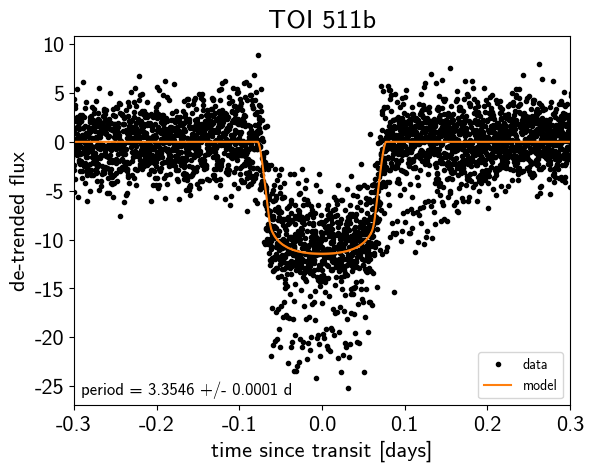

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

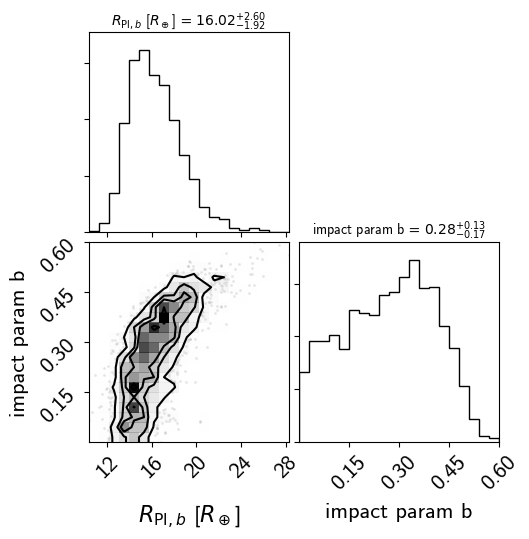

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

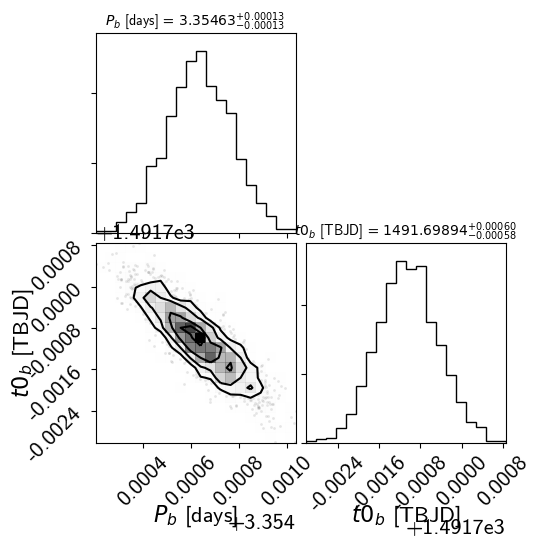

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

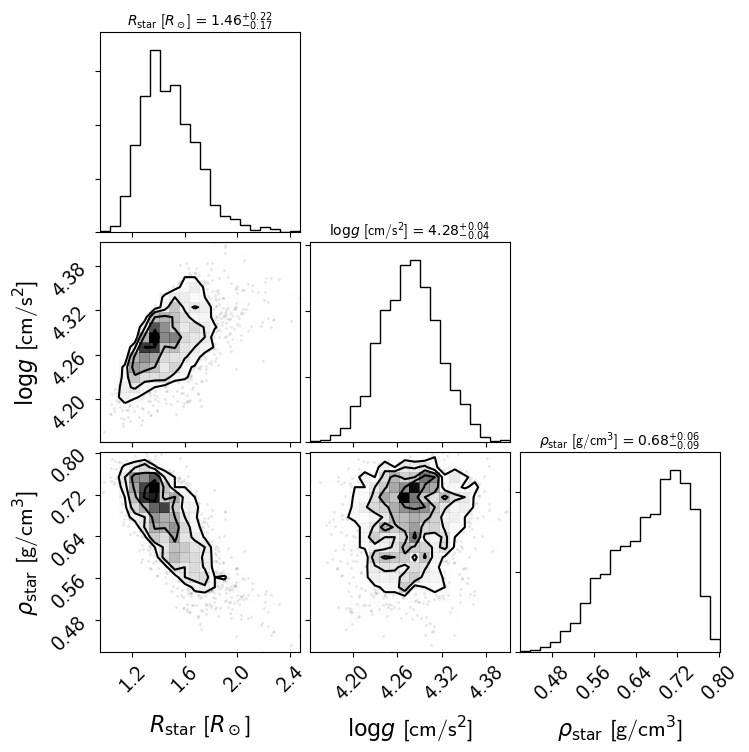

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3